# TME3 Q-Learning

In [1]:
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
from utils_rdl import smooth

#matplotlib.use("TkAgg")
matplotlib.use("Qt5AGG")

import gym
import gridworld
import numpy as np
from random import choice, random

from utils_rdl import play_one_run, train_agent
from utils_rdl import GridWorldMethods, CartPoleDiscreteMethods, LunarLanderDiscreteMethods
from utils_rdl import MountainCarContinuousMethods, PendulumContinuousMethods, LunarLanderContinuousMethods
from utils_rdl import BaseAgent, BaseMemAgent


Using matplotlib backend: Qt5Agg


## functions

In [2]:
def setparams(obj, params, default_params, verbose=True):
    """ params and default params are dict """
    for k,v in default_params.items():
        if hasattr(obj, k):
            raise ValueError
        if k in params.keys():
            val = params[k]
        else:
            val = v
        setattr(obj, k, val)
        print('{} = {}'.format(k, val))

    
def all_same(a):
    return np.all(a==a[0])


## Agents

In [3]:

class QAgentBase(BaseAgent):
    def __init__(self, action_space, params, *args, **kwargs):
        super().__init__(*args, **kwargs)
        params_default = {'eps':.1, 'default_Q':0}
        setparams(self, params, params_default)
        self.action_space = action_space
#         self.eps   = eps
#         self.default_Q = default_Q
        self.Q_dict = {}

    def getQ(self, s, a):
        if s is None or s not in self.Q_dict.keys():
            return self.default_Q
        return self.Q_dict[s][a]

    def getQ_max(self, s):
        if s is None or s not in self.Q_dict.keys():
            return self.default_Q
        return np.max(self.Q_dict[s])
    def getQ_eps_greedy(self, s):
        if s not in self.Q_dict.keys() or all_same(self.Q_dict[s]):
            return self.default_Q
        Qs = self.Q_dict[s]
        return self.eps*np.mean(Qs) + (1-self.eps)*np.max(Qs)

    def setQ(self, s, a, val):
        if s is None: return
        if s not in self.Q_dict.keys():
            self.Q_dict[s] = np.repeat(self.default_Q, self.action_space.n)
        self.Q_dict[s][a] = val

    def choose_eps_greedy(self, s):
        p = random()
        if (p < self.eps) or s not in self.Q_dict.keys() or all_same(self.Q_dict[s]):
            return self.action_space.sample()
        return self.choose_action_greedy(s)

    def choose_action_greedy(self, s):
        if s not in self.Q_dict.keys() or all_same(self.Q_dict[s]):
            return self.action_space.sample()
        return np.argmax(self.Q_dict[s])

############################################################################################



class QLearningAgent(QAgentBase):
    def __init__(self, action_space, params, *args, **kwargs):
        super().__init__(action_space, params, *args, **kwargs)
        params_default = {'alpha':0.5, 'gamma':0.99}
        setparams(self, params, params_default)

    def observe(self, s0, a0, r0, s1, done0):
        Q_s0_a0 = self.getQ(s0, a0)
        Q_s0_a0 = Q_s0_a0 + self.alpha*(r0 + self.gamma*self.getQ_max(s1) - Q_s0_a0)
        self.setQ(s0, a0, Q_s0_a0)
        if done0:
            self.setQ(s1, 0, 0.)
        
    def act(self, s1):
        a1 = self.choose_action_greedy(s1)
        return a1

############################################################################################



class SARSAAgent(QAgentBase):
    """ choose next action before update"""
    def __init__(self, action_space,params, *args, **kwargs):
        super().__init__(action_space, params, *args, **kwargs)
        params_default = {'alpha':0.5, 'gamma':0.99,}
        setparams(self, params, params_default)        
        self.next_action = None
        self.last_state  = None
        
    def observe(self, s0, a0, r0, s1, done0):
        a1 = self.choose_eps_greedy(s1)
        self.next_action = a1
        self.last_state = s1
        Q_s0_a0 = self.getQ(s0, a0)
        Q_s0_a0 = Q_s0_a0 + self.alpha*(r0 + self.gamma*self.getQ_eps_greedy(s1) - Q_s0_a0)
        self.setQ(s0, a0, Q_s0_a0)
        if done0:
            self.setQ(s1, 0, 0.)
            self.next_action = None
        
    def act(self, s1):
        if self.next_action is not None and self.last_state == s1:
            return self.next_action
        return self.choose_eps_greedy(s1)

############################################################################################



class DynaQAgent(QAgentBase):
    def __init__(self, action_space, params, *args, **kwargs):
        super().__init__(action_space, params, *args, **kwargs)
        params_default = { 'alpha':0.5, 'gamma':0.99, 'alpha_R':.5, 'k':10,}
        setparams(self, params, params_default)
#         self.alpha   = alpha
#         self.alpha_R = alpha_R
#         self.gamma   = gamma
#         self.k = k
        self.states = []
        self.P = {}
        self.R = {}

        
    def observe(self, s0, a0, r0, s1, done0):
        if s1 not in self.states:
            self.states.append(s1)

        Q_s0_a0 = self.getQ(s0, a0)
        Q_s0_a0 = Q_s0_a0 + self.alpha*(r0 + self.gamma*self.getQ_max(s1) - Q_s0_a0)
        self.setQ(s0, a0, Q_s0_a0)

        R0 = self.R.get((s0,a0,s1), 0.)
        self.R[(s0,a0,s1)] = R0 + self.alpha_R*(r0-R0)
        for ss in self.states:
            if ss==s1:
                x = 1
            else :
                x = 0
            P0 = self.P.get((s0,a0,ss), 0.)
            self.P[(s0,a0,ss)] = P0 + self.alpha_R*(x -P0)

        for i in range(self.k):
            sr = choice(self.states)
            ar = self.action_space.sample()
            Q0 = self.getQ(sr, ar)
            rsum = 0.
            for ss in self.states:
                rsum += self.P.get((sr,ar,ss),0)*self.R.get((sr,ar,ss),0) + self.gamma*self.getQ_max(ss)
            Q0 = Q0 + self.alpha*(rsum-Q0)
            self.setQ(sr, ar, Q0)

        if done0:
            self.setQ(s1, 0, 0.)
    
    def act(self, s1):
        a1 = self.choose_eps_greedy(s1)
        return a1



## experiments

env_name = 'gridworld-v0'
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 4 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n']


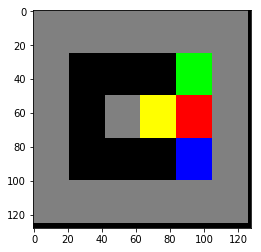

In [23]:
## 1st map

env_methods = GridWorldMethods()
env = gym.make(env_methods.get_env_name())
plan_idx = 1
squares_values = {0: -0.001, 3: 1, 4: 1, 5: -1, 6: -1}
env.setPlan("gridworldPlans/plan{}.txt".format(plan_idx), squares_values)
env.verbose = 1
env.render()
env.verbose = 0

eps = 0.1
default_Q = 0.1
alpha = 0.01
gamma = 0.9999
Episode 1	num_iter=3	DONE    	rsum=-1.002
Episode 2	num_iter=1	DONE    	rsum=-1
Episode 3	num_iter=7	DONE    	rsum=1.995
Episode 4	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 5	num_iter=17	DONE    	rsum=0.984
Episode 6	num_iter=1	DONE    	rsum=-1
Episode 7	num_iter=32	DONE    	rsum=-0.030000000000000027
Episode 8	num_iter=20	DONE    	rsum=-0.018000000000000016
Episode 9	num_iter=12	DONE    	rsum=1.99
Episode 10	num_iter=17	DONE    	rsum=1.9849999999999999
Episode 11	num_iter=3	DONE    	rsum=-1.002
Episode 12	num_iter=72	DONE    	rsum=1.93
Episode 13	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 14	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 15	num_iter=81	DONE    	rsum=-0.07900000000000007
Episode 16	num_iter=257	DONE    	rsum=1.7449999999999997
Episode 17	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 18	num_iter=1	DONE    	rsum=-1
Episode 19	num_iter=3	DONE    	rsum=-0.0010000000000000009
Epis

Episode 185	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 186	num_iter=178	DONE    	rsum=-0.17600000000000016
Episode 187	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 188	num_iter=43	DONE    	rsum=-0.041000000000000036
Episode 189	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 190	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 191	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 192	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 193	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 194	num_iter=1	DONE    	rsum=-1
Episode 195	num_iter=4	DONE    	rsum=1.998
Episode 196	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 197	num_iter=143	DONE    	rsum=1.859
Episode 198	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 199	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 200	num_iter=1	DONE    	rsum=-1
Episode 201	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 202	num_iter=88	DONE    	rsum=1.914
Episode 203	num_iter

Episode 433	num_iter=13	DONE    	rsum=1.9889999999999999
Episode 434	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 435	num_iter=52	DONE    	rsum=1.95
Episode 436	num_iter=1	DONE    	rsum=-1
Episode 437	num_iter=4	DONE    	rsum=1.998
Episode 438	num_iter=59	DONE    	rsum=-0.05700000000000005
Episode 439	num_iter=53	DONE    	rsum=1.9489999999999998
Episode 440	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 441	num_iter=82	DONE    	rsum=1.92
Episode 442	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 443	num_iter=10	DONE    	rsum=1.992
Episode 444	num_iter=1	DONE    	rsum=-1
Episode 445	num_iter=1	DONE    	rsum=-1
Episode 446	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 447	num_iter=57	DONE    	rsum=-0.05500000000000005
Episode 448	num_iter=8	DONE    	rsum=1.994
Episode 449	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 450	num_iter=161	DONE    	rsum=-0.15900000000000014
Episode 451	num_iter=1	DONE    	rsum=-1
Episode 452	num_iter=259	DONE    	

Episode 651	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 652	num_iter=317	DONE    	rsum=1.6849999999999996
Episode 653	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 654	num_iter=8	DONE    	rsum=1.994
Episode 655	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 656	num_iter=1	DONE    	rsum=-1
Episode 657	num_iter=108	DONE    	rsum=-0.1060000000000001
Episode 658	num_iter=8	DONE    	rsum=1.994
Episode 659	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 660	num_iter=189	DONE    	rsum=1.8129999999999997
Episode 661	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 662	num_iter=4	DONE    	rsum=1.998
Episode 663	num_iter=8	DONE    	rsum=1.994
Episode 664	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 665	num_iter=2	DONE    	rsum=-1.001
Episode 666	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 667	num_iter=10	DONE    	rsum=1.992
Episode 668	num_iter=4	DONE    	rsum=1.998
Episode 669	num_iter=113	DONE    	rsum=-0.1110000000000001
Episode 

Episode 824	num_iter=11	DONE    	rsum=1.991
Episode 825	num_iter=27	DONE    	rsum=-0.025000000000000022
Episode 826	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 827	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 828	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 829	num_iter=5	DONE    	rsum=-1.004
Episode 830	num_iter=52	DONE    	rsum=-0.050000000000000044
Episode 831	num_iter=13	DONE    	rsum=1.9889999999999999
Episode 832	num_iter=281	DONE    	rsum=1.7209999999999996
Episode 833	num_iter=10	DONE    	rsum=1.992
Episode 834	num_iter=4	DONE    	rsum=1.998
Episode 835	num_iter=3	DONE    	rsum=-1.002
Episode 836	num_iter=56	DONE    	rsum=1.946
Episode 837	num_iter=1	DONE    	rsum=-1
Episode 838	num_iter=221	DONE    	rsum=1.7809999999999997
Episode 839	num_iter=1	DONE    	rsum=-1
Episode 840	num_iter=2	DONE    	rsum=-1.001
Episode 841	num_iter=21	DONE    	rsum=-0.019000000000000017
Episode 842	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 843	num_iter=9

Episode 1023	num_iter=184	DONE    	rsum=1.8179999999999998
Episode 1024	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 1025	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 1026	num_iter=1	DONE    	rsum=-1
Episode 1027	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 1028	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 1029	num_iter=13	DONE    	rsum=1.9889999999999999
Episode 1030	num_iter=19	DONE    	rsum=1.983
Episode 1031	num_iter=27	DONE    	rsum=-1.026
Episode 1032	num_iter=81	DONE    	rsum=-0.07900000000000007
Episode 1033	num_iter=45	DONE    	rsum=1.9569999999999999
Episode 1034	num_iter=49	DONE    	rsum=-0.04700000000000004
Episode 1035	num_iter=18	DONE    	rsum=1.984
Episode 1036	num_iter=94	DONE    	rsum=-0.09200000000000008
Episode 1037	num_iter=14	DONE    	rsum=1.988
Episode 1038	num_iter=11	DONE    	rsum=1.991
Episode 1039	num_iter=11	DONE    	rsum=1.991
Episode 1040	num_iter=2	DONE    	rsum=-1.001
Episode 1041	num_iter=168	DONE    	rsum=-0.1

Episode 1214	num_iter=300	DONE    	rsum=1.7019999999999997
Episode 1215	num_iter=14	DONE    	rsum=1.988
Episode 1216	num_iter=1	DONE    	rsum=-1
Episode 1217	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 1218	num_iter=291	DONE    	rsum=1.7109999999999999
Episode 1219	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 1220	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 1221	num_iter=14	DONE    	rsum=1.988
Episode 1222	num_iter=2	DONE    	rsum=-1.001
Episode 1223	num_iter=3	DONE    	rsum=-1.002
Episode 1224	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1225	num_iter=60	DONE    	rsum=-0.05800000000000005
Episode 1226	num_iter=184	DONE    	rsum=1.8179999999999998
Episode 1227	num_iter=1	DONE    	rsum=-1
Episode 1228	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 1229	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 1230	num_iter=2	DONE    	rsum=-1.001
Episode 1231	num_iter=6	DONE    	rsum=1.996
Episode 1232	num_iter=5	DONE    	rsum=-0.00300000

Episode 1393	num_iter=157	DONE    	rsum=-0.15500000000000014
Episode 1394	num_iter=99	DONE    	rsum=1.903
Episode 1395	num_iter=25	DONE    	rsum=1.9769999999999999
Episode 1396	num_iter=10	DONE    	rsum=1.992
Episode 1397	num_iter=45	DONE    	rsum=-0.04300000000000004
Episode 1398	num_iter=4	DONE    	rsum=1.998
Episode 1399	num_iter=1	DONE    	rsum=-1
Episode 1400	num_iter=18	DONE    	rsum=-0.016000000000000014
Episode 1401	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 1402	num_iter=6	DONE    	rsum=1.996
Episode 1403	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 1404	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 1405	num_iter=71	DONE    	rsum=-0.06900000000000006
Episode 1406	num_iter=136	DONE    	rsum=-0.13400000000000012
Episode 1407	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 1408	num_iter=267	DONE    	rsum=1.7349999999999999
Episode 1409	num_iter=31	DONE    	rsum=-0.029000000000000026
Episode 1410	num_iter=82	DONE    	rsum=1.92
Episode 1411	

Episode 1598	num_iter=23	DONE    	rsum=1.979
Episode 1599	num_iter=4	DONE    	rsum=1.998
Episode 1600	num_iter=158	DONE    	rsum=-0.15600000000000014
Episode 1601	num_iter=4	DONE    	rsum=1.998
Episode 1602	num_iter=165	DONE    	rsum=1.8369999999999997
Episode 1603	num_iter=12	DONE    	rsum=1.99
Episode 1604	num_iter=59	DONE    	rsum=1.943
Episode 1605	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 1606	num_iter=7	DONE    	rsum=1.995
Episode 1607	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 1608	num_iter=10	DONE    	rsum=1.992
Episode 1609	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 1610	num_iter=10	DONE    	rsum=1.992
Episode 1611	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 1612	num_iter=11	DONE    	rsum=1.991
Episode 1613	num_iter=4	DONE    	rsum=1.998
Episode 1614	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 1615	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 1616	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1617	num_

Episode 1752	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 1753	num_iter=2	DONE    	rsum=-1.001
Episode 1754	num_iter=1	DONE    	rsum=-1
Episode 1755	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1756	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1757	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 1758	num_iter=248	DONE    	rsum=1.7539999999999998
Episode 1759	num_iter=482	DONE    	rsum=-0.4800000000000004
Episode 1760	num_iter=141	DONE    	rsum=1.8609999999999998
Episode 1761	num_iter=6	DONE    	rsum=1.996
Episode 1762	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 1763	num_iter=260	DONE    	rsum=1.7419999999999998
Episode 1764	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 1765	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 1766	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 1767	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1768	num_iter=213	DONE    	rsum=-0.2110000000000002
Episode 1769	num_iter=383	DONE    	r

Episode 1901	num_iter=446	DONE    	rsum=-0.4440000000000004
Episode 1902	num_iter=160	DONE    	rsum=1.8419999999999999
Episode 1903	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 1904	num_iter=2	DONE    	rsum=-1.001
Episode 1905	num_iter=470	DONE    	rsum=1.5319999999999996
Episode 1906	num_iter=247	DONE    	rsum=1.755
Episode 1907	num_iter=82	DONE    	rsum=1.92
Episode 1908	num_iter=284	DONE    	rsum=1.7179999999999997
Episode 1909	num_iter=162	DONE    	rsum=-0.16000000000000014
Episode 1910	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 1911	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 1912	num_iter=93	DONE    	rsum=-0.09100000000000008
Episode 1913	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1914	num_iter=252	DONE    	rsum=1.7499999999999998
Episode 1915	num_iter=199	DONE    	rsum=1.803
Episode 1916	num_iter=1	DONE    	rsum=-1
Episode 1917	num_iter=20	DONE    	rsum=1.982
Episode 1918	num_iter=47	DONE    	rsum=1.955
Episode 1919	num_iter=126	DONE   

Episode 2089	num_iter=185	DONE    	rsum=1.8169999999999997
Episode 2090	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 2091	num_iter=31	DONE    	rsum=-0.029000000000000026
Episode 2092	num_iter=23	DONE    	rsum=1.979
Episode 2093	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 2094	num_iter=44	DONE    	rsum=-0.04200000000000004
Episode 2095	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 2096	num_iter=30	DONE    	rsum=-0.028000000000000025
Episode 2097	num_iter=131	DONE    	rsum=-0.12900000000000011
Episode 2098	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 2099	num_iter=4	DONE    	rsum=-1.003
Episode 2100	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 2101	num_iter=8	DONE    	rsum=1.994
Episode 2102	num_iter=1	DONE    	rsum=-1
Episode 2103	num_iter=1	DONE    	rsum=-1
Episode 2104	num_iter=23	DONE    	rsum=-0.02100000000000002
Episode 2105	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 2106	num_iter=83	DONE    	rsum=0.9179999999999999
Ep

Episode 2245	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 2246	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 2247	num_iter=15	DONE    	rsum=1.987
Episode 2248	num_iter=1	DONE    	rsum=-1
Episode 2249	num_iter=8	DONE    	rsum=1.994
Episode 2250	num_iter=1	DONE    	rsum=-1
Episode 2251	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 2252	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 2253	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 2254	num_iter=12	DONE    	rsum=1.99
Episode 2255	num_iter=4	DONE    	rsum=-1.003
Episode 2256	num_iter=4	DONE    	rsum=-1.003
Episode 2257	num_iter=1	DONE    	rsum=-1
Episode 2258	num_iter=10	DONE    	rsum=1.992
Episode 2259	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 2260	num_iter=97	DONE    	rsum=1.9049999999999998
Episode 2261	num_iter=6	DONE    	rsum=1.996
Episode 2262	num_iter=27	DONE    	rsum=1.975
Episode 2263	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 2264	num_iter=3	DONE    	rsum=

Episode 2462	num_iter=30	DONE    	rsum=1.972
Episode 2463	num_iter=28	DONE    	rsum=-0.026000000000000023
Episode 2464	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 2465	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 2466	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 2467	num_iter=31	DONE    	rsum=-0.029000000000000026
Episode 2468	num_iter=49	DONE    	rsum=1.9529999999999998
Episode 2469	num_iter=4	DONE    	rsum=1.998
Episode 2470	num_iter=14	DONE    	rsum=1.988
Episode 2471	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 2472	num_iter=4	DONE    	rsum=1.998
Episode 2473	num_iter=1	DONE    	rsum=-1
Episode 2474	num_iter=26	DONE    	rsum=-0.02400000000000002
Episode 2475	num_iter=159	DONE    	rsum=1.843
Episode 2476	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 2477	num_iter=32	DONE    	rsum=-0.030000000000000027
Episode 2478	num_iter=5	DONE    	rsum=-1.004
Episode 2479	num_iter=16	DONE    	rsum=1.986
Episode 2480	num_iter=8	DONE    	rsum=1.

Episode 2723	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 2724	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 2725	num_iter=2	DONE    	rsum=-1.001
Episode 2726	num_iter=1	DONE    	rsum=-1
Episode 2727	num_iter=1	DONE    	rsum=-1
Episode 2728	num_iter=2	DONE    	rsum=-1.001
Episode 2729	num_iter=1	DONE    	rsum=-1
Episode 2730	num_iter=1	DONE    	rsum=-1
Episode 2731	num_iter=2	DONE    	rsum=-1.001
Episode 2732	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 2733	num_iter=21	DONE    	rsum=1.9809999999999999
Episode 2734	num_iter=1	DONE    	rsum=-1
Episode 2735	num_iter=4	DONE    	rsum=1.998
Episode 2736	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 2737	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 2738	num_iter=234	DONE    	rsum=-0.2320000000000002
Episode 2739	num_iter=8	DONE    	rsum=1.994
Episode 2740	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 2741	num_iter=20	DONE    	rsum=-0.018000000000000016
Episode 2742	num_iter=3	DONE   

Episode 2936	num_iter=162	DONE    	rsum=1.8399999999999999
Episode 2937	num_iter=11	DONE    	rsum=1.991
Episode 2938	num_iter=1	DONE    	rsum=-1
Episode 2939	num_iter=105	DONE    	rsum=1.8969999999999998
Episode 2940	num_iter=98	DONE    	rsum=1.904
Episode 2941	num_iter=37	DONE    	rsum=1.9649999999999999
Episode 2942	num_iter=94	DONE    	rsum=1.908
Episode 2943	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 2944	num_iter=227	DONE    	rsum=1.775
Episode 2945	num_iter=81	DONE    	rsum=1.9209999999999998
Episode 2946	num_iter=24	DONE    	rsum=-0.02200000000000002
Episode 2947	num_iter=1	DONE    	rsum=-1
Episode 2948	num_iter=314	DONE    	rsum=-0.3120000000000003
Episode 2949	num_iter=79	DONE    	rsum=1.923
Episode 2950	num_iter=30	DONE    	rsum=1.972
Episode 2951	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 2952	num_iter=13	DONE    	rsum=1.9889999999999999
Episode 2953	num_iter=77	DONE    	rsum=1.9249999999999998
Episode 2954	num_iter=9	DONE    	rsum=-0.00700000000000

Episode 3099	num_iter=55	DONE    	rsum=1.947
Episode 3100	num_iter=1	DONE    	rsum=-1
Episode 3101	num_iter=16	DONE    	rsum=1.986
Episode 3102	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 3103	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 3104	num_iter=140	DONE    	rsum=-0.13800000000000012
Episode 3105	num_iter=337	DONE    	rsum=-0.3350000000000003
Episode 3106	num_iter=1	DONE    	rsum=-1
Episode 3107	num_iter=12	DONE    	rsum=1.99
Episode 3108	num_iter=27	DONE    	rsum=1.975
Episode 3109	num_iter=6	DONE    	rsum=1.996
Episode 3110	num_iter=1	DONE    	rsum=-1
Episode 3111	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 3112	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 3113	num_iter=1	DONE    	rsum=-1
Episode 3114	num_iter=8	DONE    	rsum=1.994
Episode 3115	num_iter=2	DONE    	rsum=-1.001
Episode 3116	num_iter=84	DONE    	rsum=1.918
Episode 3117	num_iter=25	DONE    	rsum=1.9769999999999999
Episode 3118	num_iter=1	DONE    	rsum=-1
Episode 3119	num

Episode 3284	num_iter=325	DONE    	rsum=1.6769999999999996
Episode 3285	num_iter=84	DONE    	rsum=-0.08200000000000007
Episode 3286	num_iter=1	DONE    	rsum=-1
Episode 3287	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 3288	num_iter=152	DONE    	rsum=-0.15000000000000013
Episode 3289	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 3290	num_iter=51	DONE    	rsum=-0.049000000000000044
Episode 3291	num_iter=50	DONE    	rsum=1.952
Episode 3292	num_iter=52	DONE    	rsum=-0.050000000000000044
Episode 3293	num_iter=87	DONE    	rsum=1.915
Episode 3294	num_iter=54	DONE    	rsum=1.948
Episode 3295	num_iter=120	DONE    	rsum=1.882
Episode 3296	num_iter=1	DONE    	rsum=-1
Episode 3297	num_iter=56	DONE    	rsum=-0.05400000000000005
Episode 3298	num_iter=1	DONE    	rsum=-1
Episode 3299	num_iter=56	DONE    	rsum=-0.05400000000000005
Episode 3300	num_iter=83	DONE    	rsum=1.919
Episode 3301	num_iter=35	DONE    	rsum=1.967
Episode 3302	num_iter=26	DONE    	rsum=1.976
Episode 3303	num_

Episode 3455	num_iter=99	DONE    	rsum=1.903
Episode 3456	num_iter=112	DONE    	rsum=-0.1100000000000001
Episode 3457	num_iter=1	DONE    	rsum=-1
Episode 3458	num_iter=1	DONE    	rsum=-1
Episode 3459	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 3460	num_iter=41	DONE    	rsum=0.96
Episode 3461	num_iter=1	DONE    	rsum=-1
Episode 3462	num_iter=91	DONE    	rsum=-0.08900000000000008
Episode 3463	num_iter=39	DONE    	rsum=-0.03700000000000003
Episode 3464	num_iter=122	DONE    	rsum=1.88
Episode 3465	num_iter=229	DONE    	rsum=-0.2270000000000002
Episode 3466	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 3467	num_iter=139	DONE    	rsum=-0.13700000000000012
Episode 3468	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 3469	num_iter=3	DONE    	rsum=-1.002
Episode 3470	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 3471	num_iter=145	DONE    	rsum=1.8569999999999998
Episode 3472	num_iter=253	DONE    	rsum=-0.2510000000000002
Episode 3473	num_iter=94	DONE    	rsum

Episode 3641	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 3642	num_iter=287	DONE    	rsum=1.7149999999999999
Episode 3643	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 3644	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 3645	num_iter=21	DONE    	rsum=1.9809999999999999
Episode 3646	num_iter=14	DONE    	rsum=1.988
Episode 3647	num_iter=39	DONE    	rsum=1.963
Episode 3648	num_iter=17	DONE    	rsum=1.9849999999999999
Episode 3649	num_iter=1	DONE    	rsum=-1
Episode 3650	num_iter=20	DONE    	rsum=-0.018000000000000016
Episode 3651	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 3652	num_iter=34	DONE    	rsum=-0.03200000000000003
Episode 3653	num_iter=1	DONE    	rsum=-1
Episode 3654	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 3655	num_iter=119	DONE    	rsum=1.883
Episode 3656	num_iter=4	DONE    	rsum=-1.003
Episode 3657	num_iter=3	DONE    	rsum=-1.002
Episode 3658	num_iter=27	DONE    	rsum=-0.025000000000000022
Episode 3659	num_iter=17	DONE    	rs

Episode 3846	num_iter=16	DONE    	rsum=1.986
Episode 3847	num_iter=1	DONE    	rsum=-1
Episode 3848	num_iter=27	DONE    	rsum=-0.025000000000000022
Episode 3849	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 3850	num_iter=1	DONE    	rsum=-1
Episode 3851	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 3852	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 3853	num_iter=24	DONE    	rsum=1.978
Episode 3854	num_iter=8	DONE    	rsum=1.994
Episode 3855	num_iter=72	DONE    	rsum=-0.07000000000000006
Episode 3856	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 3857	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 3858	num_iter=2	DONE    	rsum=-1.001
Episode 3859	num_iter=2	DONE    	rsum=-1.001
Episode 3860	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 3861	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 3862	num_iter=361	DONE    	rsum=-0.3590000000000003
Episode 3863	num_iter=6	DONE    	rsum=1.996
Episode 3864	num_iter=1	DONE    	rsum=-1
E

Episode 4077	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4078	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 4079	num_iter=12	DONE    	rsum=1.99
Episode 4080	num_iter=1	DONE    	rsum=-1
Episode 4081	num_iter=1	DONE    	rsum=-1
Episode 4082	num_iter=1	DONE    	rsum=-1
Episode 4083	num_iter=10	DONE    	rsum=1.992
Episode 4084	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 4085	num_iter=6	DONE    	rsum=1.996
Episode 4086	num_iter=23	DONE    	rsum=1.979
Episode 4087	num_iter=1	DONE    	rsum=-1
Episode 4088	num_iter=8	DONE    	rsum=1.994
Episode 4089	num_iter=7	DONE    	rsum=1.995
Episode 4090	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 4091	num_iter=46	DONE    	rsum=-0.04400000000000004
Episode 4092	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4093	num_iter=1	DONE    	rsum=-1
Episode 4094	num_iter=11	DONE    	rsum=1.991
Episode 4095	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4096	num_iter=3	DONE    	rsum=-0.0010000000000000009
Ep

Episode 4266	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 4267	num_iter=44	DONE    	rsum=-0.04200000000000004
Episode 4268	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4269	num_iter=29	DONE    	rsum=1.9729999999999999
Episode 4270	num_iter=11	DONE    	rsum=1.991
Episode 4271	num_iter=4	DONE    	rsum=1.998
Episode 4272	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 4273	num_iter=4	DONE    	rsum=1.998
Episode 4274	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4275	num_iter=1	DONE    	rsum=-1
Episode 4276	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4277	num_iter=14	DONE    	rsum=1.988
Episode 4278	num_iter=22	DONE    	rsum=1.98
Episode 4279	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 4280	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 4281	num_iter=18	DONE    	rsum=1.984
Episode 4282	num_iter=1	DONE    	rsum=-1
Episode 4283	num_iter=72	DONE    	rsum=1.93
Episode 4284	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode

Episode 4467	num_iter=162	DONE    	rsum=1.8399999999999999
Episode 4468	num_iter=50	DONE    	rsum=-0.04800000000000004
Episode 4469	num_iter=35	DONE    	rsum=-0.03300000000000003
Episode 4470	num_iter=236	DONE    	rsum=-0.2340000000000002
Episode 4471	num_iter=1	DONE    	rsum=-1
Episode 4472	num_iter=10	DONE    	rsum=1.992
Episode 4473	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 4474	num_iter=12	DONE    	rsum=1.99
Episode 4475	num_iter=10	DONE    	rsum=1.992
Episode 4476	num_iter=17	DONE    	rsum=1.9849999999999999
Episode 4477	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 4478	num_iter=4	DONE    	rsum=1.998
Episode 4479	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 4480	num_iter=1	DONE    	rsum=-1
Episode 4481	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4482	num_iter=1	DONE    	rsum=-1
Episode 4483	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 4484	num_iter=52	DONE    	rsum=-0.050000000000000044
Episode 4485	num_iter=1	DONE    	rsum

Episode 4654	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 4655	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 4656	num_iter=10	DONE    	rsum=1.992
Episode 4657	num_iter=1	DONE    	rsum=-1
Episode 4658	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 4659	num_iter=60	DONE    	rsum=-0.05800000000000005
Episode 4660	num_iter=100	DONE    	rsum=-0.09800000000000009
Episode 4661	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 4662	num_iter=42	DONE    	rsum=1.96
Episode 4663	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 4664	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 4665	num_iter=98	DONE    	rsum=-0.09600000000000009
Episode 4666	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 4667	num_iter=8	DONE    	rsum=1.994
Episode 4668	num_iter=24	DONE    	rsum=1.978
Episode 4669	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 4670	num_iter=12	DONE    	rsum=1.99
Episode 4671	num_iter=82	DONE    	rsum=-0.08000000000000007
Episode 46

Episode 4833	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 4834	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 4835	num_iter=18	DONE    	rsum=-0.016000000000000014
Episode 4836	num_iter=3	DONE    	rsum=-1.002
Episode 4837	num_iter=1	DONE    	rsum=-1
Episode 4838	num_iter=1	DONE    	rsum=-1
Episode 4839	num_iter=1	DONE    	rsum=-1
Episode 4840	num_iter=1	DONE    	rsum=-1
Episode 4841	num_iter=2	DONE    	rsum=-1.001
Episode 4842	num_iter=27	DONE    	rsum=1.975
Episode 4843	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 4844	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 4845	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 4846	num_iter=26	DONE    	rsum=1.976
Episode 4847	num_iter=321	DONE    	rsum=1.6809999999999996
Episode 4848	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 4849	num_iter=104	DONE    	rsum=-0.10200000000000009
Episode 4850	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 4851	num_iter=38	DONE    	rsum=-0.03600000000000003
Ep

Episode 4995	num_iter=80	DONE    	rsum=1.922
Episode 4996	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 4997	num_iter=397	DONE    	rsum=-0.39500000000000035
Episode 4998	num_iter=64	DONE    	rsum=1.938
Episode 4999	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5000	num_iter=1	DONE    	rsum=-1
Episode 5001	num_iter=163	DONE    	rsum=-0.16100000000000014
Episode 5002	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 5003	num_iter=218	DONE    	rsum=-0.2160000000000002
Episode 5004	num_iter=69	DONE    	rsum=1.9329999999999998
Episode 5005	num_iter=471	DONE    	rsum=-0.4690000000000004
Episode 5006	num_iter=190	DONE    	rsum=-0.18800000000000017
Episode 5007	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5008	num_iter=394	DONE    	rsum=-0.39200000000000035
Episode 5009	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5010	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5011	num_iter=23	DONE    	rsum=1.979
Episode 5012	num_iter=500	MAX_ITER	rsum=0.5009

Episode 5160	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5161	num_iter=476	DONE    	rsum=-0.4740000000000003
Episode 5162	num_iter=243	DONE    	rsum=-0.24100000000000021
Episode 5163	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5164	num_iter=79	DONE    	rsum=1.923
Episode 5165	num_iter=213	DONE    	rsum=1.7889999999999997
Episode 5166	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5167	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5168	num_iter=162	DONE    	rsum=-0.16000000000000014
Episode 5169	num_iter=359	DONE    	rsum=1.6429999999999998
Episode 5170	num_iter=2	DONE    	rsum=-1.001
Episode 5171	num_iter=452	DONE    	rsum=1.5499999999999996
Episode 5172	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5173	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5174	num_iter=265	DONE    	rsum=-0.26300000000000023
Episode 5175	num_iter=66	DONE    	rsum=1.936
Episode 5176	num_iter=117	DONE    	rsum=1.8849999999999998
Episode 5177	num_iter=2	DONE  

Episode 5330	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5331	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5332	num_iter=322	DONE    	rsum=1.6799999999999997
Episode 5333	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5334	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5335	num_iter=260	DONE    	rsum=-0.25800000000000023
Episode 5336	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5337	num_iter=492	DONE    	rsum=1.5099999999999996
Episode 5338	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5339	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5340	num_iter=358	DONE    	rsum=-0.3560000000000003
Episode 5341	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5342	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5343	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5344	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5345	num_iter=1	DONE    	rsum=-1
Episode 5346	num_iter=4	DONE    	rsum=1.998
Episode 5347	num_iter=81	

Episode 5522	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5523	num_iter=356	DONE    	rsum=-0.3540000000000003
Episode 5524	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5525	num_iter=1	DONE    	rsum=-1
Episode 5526	num_iter=2	DONE    	rsum=-1.001
Episode 5527	num_iter=3	DONE    	rsum=-1.002
Episode 5528	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5529	num_iter=1	DONE    	rsum=-1
Episode 5530	num_iter=1	DONE    	rsum=-1
Episode 5531	num_iter=1	DONE    	rsum=-1
Episode 5532	num_iter=1	DONE    	rsum=-1
Episode 5533	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5534	num_iter=1	DONE    	rsum=-1
Episode 5535	num_iter=1	DONE    	rsum=-1
Episode 5536	num_iter=1	DONE    	rsum=-1
Episode 5537	num_iter=1	DONE    	rsum=-1
Episode 5538	num_iter=1	DONE    	rsum=-1
Episode 5539	num_iter=1	DONE    	rsum=-1
Episode 5540	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5541	num_iter=1	DONE    	rsum=-1
Episode 5542	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Epis

Episode 5696	num_iter=218	DONE    	rsum=1.7839999999999998
Episode 5697	num_iter=1	DONE    	rsum=-1
Episode 5698	num_iter=1	DONE    	rsum=-1
Episode 5699	num_iter=1	DONE    	rsum=-1
Episode 5700	num_iter=1	DONE    	rsum=-1
Episode 5701	num_iter=1	DONE    	rsum=-1
Episode 5702	num_iter=1	DONE    	rsum=-1
Episode 5703	num_iter=1	DONE    	rsum=-1
Episode 5704	num_iter=180	DONE    	rsum=1.8219999999999998
Episode 5705	num_iter=1	DONE    	rsum=-1
Episode 5706	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5707	num_iter=1	DONE    	rsum=-1
Episode 5708	num_iter=2	DONE    	rsum=-1.001
Episode 5709	num_iter=352	DONE    	rsum=1.6499999999999997
Episode 5710	num_iter=133	DONE    	rsum=1.8689999999999998
Episode 5711	num_iter=3	DONE    	rsum=-1.002
Episode 5712	num_iter=1	DONE    	rsum=-1
Episode 5713	num_iter=105	DONE    	rsum=1.8969999999999998
Episode 5714	num_iter=64	DONE    	rsum=1.938
Episode 5715	num_iter=2	DONE    	rsum=-1.001
Episode 5716	num_iter=54	DONE    	rsum=-0.052000000000

Episode 5888	num_iter=171	DONE    	rsum=-0.16900000000000015
Episode 5889	num_iter=31	DONE    	rsum=1.971
Episode 5890	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 5891	num_iter=13	DONE    	rsum=1.9889999999999999
Episode 5892	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 5893	num_iter=3	DONE    	rsum=-1.002
Episode 5894	num_iter=1	DONE    	rsum=-1
Episode 5895	num_iter=1	DONE    	rsum=-1
Episode 5896	num_iter=93	DONE    	rsum=-1.092
Episode 5897	num_iter=85	DONE    	rsum=-0.08300000000000007
Episode 5898	num_iter=4	DONE    	rsum=1.998
Episode 5899	num_iter=176	DONE    	rsum=-0.17400000000000015
Episode 5900	num_iter=99	DONE    	rsum=-0.09700000000000009
Episode 5901	num_iter=66	DONE    	rsum=-0.06400000000000006
Episode 5902	num_iter=1	DONE    	rsum=-1
Episode 5903	num_iter=167	DONE    	rsum=1.835
Episode 5904	num_iter=36	DONE    	rsum=1.966
Episode 5905	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5906	num_iter=30	DONE    	rsum=1.972
Episode 5907	num_i

Episode 6070	num_iter=77	DONE    	rsum=1.9249999999999998
Episode 6071	num_iter=161	DONE    	rsum=-0.15900000000000014
Episode 6072	num_iter=78	DONE    	rsum=-0.07600000000000007
Episode 6073	num_iter=81	DONE    	rsum=-0.07900000000000007
Episode 6074	num_iter=13	DONE    	rsum=-0.01100000000000001
Episode 6075	num_iter=4	DONE    	rsum=-1.003
Episode 6076	num_iter=47	DONE    	rsum=-0.04500000000000004
Episode 6077	num_iter=80	DONE    	rsum=1.922
Episode 6078	num_iter=183	DONE    	rsum=1.819
Episode 6079	num_iter=40	DONE    	rsum=-0.038000000000000034
Episode 6080	num_iter=1	DONE    	rsum=-1
Episode 6081	num_iter=61	DONE    	rsum=1.9409999999999998
Episode 6082	num_iter=304	DONE    	rsum=1.6979999999999997
Episode 6083	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 6084	num_iter=24	DONE    	rsum=-0.02200000000000002
Episode 6085	num_iter=11	DONE    	rsum=1.991
Episode 6086	num_iter=47	DONE    	rsum=-0.04500000000000004
Episode 6087	num_iter=35	DONE    	rsum=-0.03300000000000003
E

Episode 6368	num_iter=193	DONE    	rsum=1.8089999999999997
Episode 6369	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 6370	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 6371	num_iter=4	DONE    	rsum=1.998
Episode 6372	num_iter=4	DONE    	rsum=1.998
Episode 6373	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 6374	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 6375	num_iter=3	DONE    	rsum=-1.002
Episode 6376	num_iter=1	DONE    	rsum=-1
Episode 6377	num_iter=1	DONE    	rsum=-1
Episode 6378	num_iter=1	DONE    	rsum=-1
Episode 6379	num_iter=1	DONE    	rsum=-1
Episode 6380	num_iter=1	DONE    	rsum=-1
Episode 6381	num_iter=1	DONE    	rsum=-1
Episode 6382	num_iter=1	DONE    	rsum=-1
Episode 6383	num_iter=1	DONE    	rsum=-1
Episode 6384	num_iter=64	DONE    	rsum=-0.062000000000000055
Episode 6385	num_iter=10	DONE    	rsum=1.992
Episode 6386	num_iter=1	DONE    	rsum=-1
Episode 6387	num_iter=6	DONE    	rsum=1.996
Episode 6388	num_iter=17	DONE    	rsum=-0.0150

Episode 6576	num_iter=37	DONE    	rsum=1.9649999999999999
Episode 6577	num_iter=18	DONE    	rsum=1.984
Episode 6578	num_iter=7	DONE    	rsum=1.995
Episode 6579	num_iter=1	DONE    	rsum=-1
Episode 6580	num_iter=1	DONE    	rsum=-1
Episode 6581	num_iter=7	DONE    	rsum=1.995
Episode 6582	num_iter=1	DONE    	rsum=-1
Episode 6583	num_iter=21	DONE    	rsum=1.9809999999999999
Episode 6584	num_iter=1	DONE    	rsum=-1
Episode 6585	num_iter=49	DONE    	rsum=1.9529999999999998
Episode 6586	num_iter=1	DONE    	rsum=-1
Episode 6587	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 6588	num_iter=13	DONE    	rsum=1.9889999999999999
Episode 6589	num_iter=6	DONE    	rsum=1.996
Episode 6590	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 6591	num_iter=73	DONE    	rsum=-0.07100000000000006
Episode 6592	num_iter=1	DONE    	rsum=-1
Episode 6593	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 6594	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 6595	num_iter=3	DONE    	rsum=-0.00100

Episode 6785	num_iter=8	DONE    	rsum=1.994
Episode 6786	num_iter=1	DONE    	rsum=-1
Episode 6787	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 6788	num_iter=3	DONE    	rsum=-1.002
Episode 6789	num_iter=186	DONE    	rsum=-0.18400000000000016
Episode 6790	num_iter=120	DONE    	rsum=-0.1180000000000001
Episode 6791	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 6792	num_iter=1	DONE    	rsum=-1
Episode 6793	num_iter=13	DONE    	rsum=-0.01100000000000001
Episode 6794	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 6795	num_iter=2	DONE    	rsum=-1.001
Episode 6796	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 6797	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 6798	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 6799	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 6800	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 6801	num_iter=1	DONE    	rsum=-1
Episode 6802	num_iter=6	DONE    	rsum=1.996
Episode 6803	num_iter=1	DONE  

Episode 6973	num_iter=452	DONE    	rsum=1.5499999999999998
Episode 6974	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 6975	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 6976	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 6977	num_iter=136	DONE    	rsum=-0.13400000000000012
Episode 6978	num_iter=4	DONE    	rsum=1.998
Episode 6979	num_iter=57	DONE    	rsum=1.9449999999999998
Episode 6980	num_iter=14	DONE    	rsum=1.988
Episode 6981	num_iter=50	DONE    	rsum=1.952
Episode 6982	num_iter=1	DONE    	rsum=-1
Episode 6983	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 6984	num_iter=259	DONE    	rsum=1.7429999999999999
Episode 6985	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 6986	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 6987	num_iter=4	DONE    	rsum=1.998
Episode 6988	num_iter=1	DONE    	rsum=-1
Episode 6989	num_iter=14	DONE    	rsum=1.988
Episode 6990	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 6991	num_iter=1	DONE    

Episode 7172	num_iter=307	DONE    	rsum=1.6949999999999998
Episode 7173	num_iter=8	DONE    	rsum=1.994
Episode 7174	num_iter=2	DONE    	rsum=-1.001
Episode 7175	num_iter=190	DONE    	rsum=-0.18800000000000017
Episode 7176	num_iter=8	DONE    	rsum=1.994
Episode 7177	num_iter=1	DONE    	rsum=-1
Episode 7178	num_iter=172	DONE    	rsum=1.8299999999999998
Episode 7179	num_iter=4	DONE    	rsum=1.998
Episode 7180	num_iter=234	DONE    	rsum=1.7679999999999998
Episode 7181	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 7182	num_iter=6	DONE    	rsum=1.996
Episode 7183	num_iter=4	DONE    	rsum=1.998
Episode 7184	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 7185	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7186	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 7187	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7188	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 7189	num_iter=253	DONE    	rsum=1.7489999999999997
Episode 7190	num_iter=500	MAX_ITER	r

Episode 7366	num_iter=197	DONE    	rsum=1.8049999999999997
Episode 7367	num_iter=1	DONE    	rsum=-1
Episode 7368	num_iter=1	DONE    	rsum=-1
Episode 7369	num_iter=1	DONE    	rsum=-1
Episode 7370	num_iter=1	DONE    	rsum=-1
Episode 7371	num_iter=27	DONE    	rsum=-0.025000000000000022
Episode 7372	num_iter=1	DONE    	rsum=-1
Episode 7373	num_iter=36	DONE    	rsum=-0.03400000000000003
Episode 7374	num_iter=1	DONE    	rsum=-1
Episode 7375	num_iter=1	DONE    	rsum=-1
Episode 7376	num_iter=1	DONE    	rsum=-1
Episode 7377	num_iter=1	DONE    	rsum=-1
Episode 7378	num_iter=1	DONE    	rsum=-1
Episode 7379	num_iter=1	DONE    	rsum=-1
Episode 7380	num_iter=2	DONE    	rsum=-1.001
Episode 7381	num_iter=1	DONE    	rsum=-1
Episode 7382	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7383	num_iter=1	DONE    	rsum=-1
Episode 7384	num_iter=77	DONE    	rsum=1.9249999999999998
Episode 7385	num_iter=55	DONE    	rsum=1.947
Episode 7386	num_iter=20	DONE    	rsum=1.982
Episode 7387	num_iter=256	DONE   

Episode 7537	num_iter=135	DONE    	rsum=1.867
Episode 7538	num_iter=114	DONE    	rsum=1.888
Episode 7539	num_iter=79	DONE    	rsum=-0.07700000000000007
Episode 7540	num_iter=44	DONE    	rsum=-0.04200000000000004
Episode 7541	num_iter=150	DONE    	rsum=1.8519999999999999
Episode 7542	num_iter=379	DONE    	rsum=1.6229999999999998
Episode 7543	num_iter=1	DONE    	rsum=-1
Episode 7544	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7545	num_iter=232	DONE    	rsum=-1.231
Episode 7546	num_iter=7	DONE    	rsum=1.995
Episode 7547	num_iter=1	DONE    	rsum=-1
Episode 7548	num_iter=1	DONE    	rsum=-1
Episode 7549	num_iter=258	DONE    	rsum=1.7439999999999998
Episode 7550	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 7551	num_iter=87	DONE    	rsum=1.915
Episode 7552	num_iter=103	DONE    	rsum=1.899
Episode 7553	num_iter=12	DONE    	rsum=1.99
Episode 7554	num_iter=1	DONE    	rsum=-1
Episode 7555	num_iter=153	DONE    	rsum=1.8489999999999998
Episode 7556	num_iter=61	DONE    	rsum=1.940

Episode 7699	num_iter=65	DONE    	rsum=-0.06300000000000006
Episode 7700	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 7701	num_iter=24	DONE    	rsum=-0.02200000000000002
Episode 7702	num_iter=10	DONE    	rsum=1.992
Episode 7703	num_iter=49	DONE    	rsum=1.9529999999999998
Episode 7704	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 7705	num_iter=116	DONE    	rsum=1.886
Episode 7706	num_iter=46	DONE    	rsum=1.956
Episode 7707	num_iter=51	DONE    	rsum=1.951
Episode 7708	num_iter=1	DONE    	rsum=-1
Episode 7709	num_iter=160	DONE    	rsum=1.8419999999999999
Episode 7710	num_iter=12	DONE    	rsum=1.99
Episode 7711	num_iter=234	DONE    	rsum=-0.2320000000000002
Episode 7712	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 7713	num_iter=245	DONE    	rsum=1.7569999999999997
Episode 7714	num_iter=153	DONE    	rsum=1.8489999999999998
Episode 7715	num_iter=113	DONE    	rsum=1.8889999999999998
Episode 7716	num_iter=1	DONE    	rsum=-1
Episode 7717	num_iter=6	DONE    	rsum=-0

Episode 7861	num_iter=202	DONE    	rsum=-0.20000000000000018
Episode 7862	num_iter=10	DONE    	rsum=1.992
Episode 7863	num_iter=15	DONE    	rsum=1.987
Episode 7864	num_iter=4	DONE    	rsum=1.998
Episode 7865	num_iter=6	DONE    	rsum=1.996
Episode 7866	num_iter=1	DONE    	rsum=-1
Episode 7867	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 7868	num_iter=117	DONE    	rsum=1.8849999999999998
Episode 7869	num_iter=20	DONE    	rsum=1.982
Episode 7870	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7871	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 7872	num_iter=34	DONE    	rsum=1.968
Episode 7873	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 7874	num_iter=1	DONE    	rsum=-1
Episode 7875	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 7876	num_iter=30	DONE    	rsum=-0.028000000000000025
Episode 7877	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 7878	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 7879	num_iter=30	DONE    	rsum=1.972
Epi

Episode 8071	num_iter=1	DONE    	rsum=-1
Episode 8072	num_iter=20	DONE    	rsum=-0.018000000000000016
Episode 8073	num_iter=20	DONE    	rsum=1.982
Episode 8074	num_iter=72	DONE    	rsum=1.93
Episode 8075	num_iter=13	DONE    	rsum=-0.01100000000000001
Episode 8076	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 8077	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 8078	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 8079	num_iter=160	DONE    	rsum=-0.15800000000000014
Episode 8080	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 8081	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 8082	num_iter=25	DONE    	rsum=-0.02300000000000002
Episode 8083	num_iter=13	DONE    	rsum=-0.01100000000000001
Episode 8084	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 8085	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 8086	num_iter=127	DONE    	rsum=-0.1250000000000001
Episode 8087	num_iter=1	DONE    	rsum=-1
Episode 8088	num_iter=14	DONE    	rsum=-0.01

Episode 8369	num_iter=33	DONE    	rsum=1.9689999999999999
Episode 8370	num_iter=21	DONE    	rsum=1.9809999999999999
Episode 8371	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 8372	num_iter=33	DONE    	rsum=-0.031000000000000028
Episode 8373	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 8374	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 8375	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 8376	num_iter=35	DONE    	rsum=-0.03300000000000003
Episode 8377	num_iter=1	DONE    	rsum=-1
Episode 8378	num_iter=180	DONE    	rsum=-0.17800000000000016
Episode 8379	num_iter=7	DONE    	rsum=1.995
Episode 8380	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 8381	num_iter=108	DONE    	rsum=1.894
Episode 8382	num_iter=7	DONE    	rsum=1.995
Episode 8383	num_iter=18	DONE    	rsum=1.984
Episode 8384	num_iter=1	DONE    	rsum=-1
Episode 8385	num_iter=1	DONE    	rsum=-1
Episode 8386	num_iter=1	DONE    	rsum=-1
Episode 8387	num_iter=1	DONE    	rsum=-1
Episode 8388	nu

Episode 8572	num_iter=132	DONE    	rsum=1.8699999999999999
Episode 8573	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 8574	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 8575	num_iter=22	DONE    	rsum=-0.020000000000000018
Episode 8576	num_iter=10	DONE    	rsum=1.992
Episode 8577	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 8578	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 8579	num_iter=12	DONE    	rsum=1.99
Episode 8580	num_iter=111	DONE    	rsum=0.8899999999999999
Episode 8581	num_iter=4	DONE    	rsum=-1.003
Episode 8582	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 8583	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 8584	num_iter=187	DONE    	rsum=1.815
Episode 8585	num_iter=7	DONE    	rsum=1.995
Episode 8586	num_iter=1	DONE    	rsum=-1
Episode 8587	num_iter=66	DONE    	rsum=1.936
Episode 8588	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 8589	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 8590	num_iter=1	DONE    	

Episode 8734	num_iter=165	DONE    	rsum=1.8369999999999997
Episode 8735	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 8736	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 8737	num_iter=10	DONE    	rsum=1.992
Episode 8738	num_iter=8	DONE    	rsum=1.994
Episode 8739	num_iter=12	DONE    	rsum=1.99
Episode 8740	num_iter=21	DONE    	rsum=0.98
Episode 8741	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 8742	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 8743	num_iter=13	DONE    	rsum=1.9889999999999999
Episode 8744	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 8745	num_iter=26	DONE    	rsum=-0.02400000000000002
Episode 8746	num_iter=10	DONE    	rsum=1.992
Episode 8747	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 8748	num_iter=30	DONE    	rsum=1.972
Episode 8749	num_iter=25	DONE    	rsum=1.9769999999999999
Episode 8750	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 8751	num_iter=2	DONE    	rsum=-1.001
Episode 8752	num_iter=1	DONE  

Episode 8919	num_iter=3	DONE    	rsum=-1.002
Episode 8920	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 8921	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 8922	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 8923	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 8924	num_iter=2	DONE    	rsum=-1.001
Episode 8925	num_iter=29	DONE    	rsum=1.9729999999999999
Episode 8926	num_iter=20	DONE    	rsum=1.982
Episode 8927	num_iter=1	DONE    	rsum=-1
Episode 8928	num_iter=3	DONE    	rsum=-1.002
Episode 8929	num_iter=115	DONE    	rsum=1.887
Episode 8930	num_iter=1	DONE    	rsum=-1
Episode 8931	num_iter=6	DONE    	rsum=1.996
Episode 8932	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 8933	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 8934	num_iter=6	DONE    	rsum=1.996
Episode 8935	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 8936	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 8937	num_iter=4	DONE    	rsum=1.998
Episode 8938	num_

Episode 9128	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 9129	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 9130	num_iter=355	DONE    	rsum=1.6469999999999998
Episode 9131	num_iter=82	DONE    	rsum=1.92
Episode 9132	num_iter=1	DONE    	rsum=-1
Episode 9133	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 9134	num_iter=12	DONE    	rsum=1.99
Episode 9135	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 9136	num_iter=39	DONE    	rsum=1.963
Episode 9137	num_iter=2	DONE    	rsum=-1.001
Episode 9138	num_iter=156	DONE    	rsum=1.8459999999999999
Episode 9139	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 9140	num_iter=233	DONE    	rsum=-0.2310000000000002
Episode 9141	num_iter=4	DONE    	rsum=1.998
Episode 9142	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 9143	num_iter=1	DONE    	rsum=-1
Episode 9144	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 9145	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 9146	num_iter=5	DONE    	rsum=-1.0

Episode 9330	num_iter=73	DONE    	rsum=1.9289999999999998
Episode 9331	num_iter=8	DONE    	rsum=1.994
Episode 9332	num_iter=317	DONE    	rsum=0.6839999999999997
Episode 9333	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 9334	num_iter=4	DONE    	rsum=1.998
Episode 9335	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 9336	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 9337	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 9338	num_iter=6	DONE    	rsum=1.996
Episode 9339	num_iter=22	DONE    	rsum=-0.020000000000000018
Episode 9340	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 9341	num_iter=18	DONE    	rsum=1.984
Episode 9342	num_iter=41	DONE    	rsum=-0.039000000000000035
Episode 9343	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 9344	num_iter=1	DONE    	rsum=-1
Episode 9345	num_iter=14	DONE    	rsum=1.988
Episode 9346	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 9347	num_iter=7	DONE    	rsum=1.995
Episode 9348	num_iter=7	DON

Episode 9575	num_iter=182	DONE    	rsum=-0.18000000000000016
Episode 9576	num_iter=4	DONE    	rsum=1.998
Episode 9577	num_iter=1	DONE    	rsum=-1
Episode 9578	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 9579	num_iter=82	DONE    	rsum=-0.08000000000000007
Episode 9580	num_iter=13	DONE    	rsum=1.9889999999999999
Episode 9581	num_iter=1	DONE    	rsum=-1
Episode 9582	num_iter=8	DONE    	rsum=1.994
Episode 9583	num_iter=1	DONE    	rsum=-1
Episode 9584	num_iter=4	DONE    	rsum=1.998
Episode 9585	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 9586	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 9587	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 9588	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 9589	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 9590	num_iter=1	DONE    	rsum=-1
Episode 9591	num_iter=4	DONE    	rsum=1.998
Episode 9592	num_iter=1	DONE    	rsum=-1
Episode 9593	num_iter=6	DONE    	rsum=1.996
Episode 9594	num_iter=3	DONE   

Episode 9797	num_iter=319	DONE    	rsum=-0.31700000000000017
Episode 9798	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 9799	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 9800	num_iter=46	DONE    	rsum=1.956
Episode 9801	num_iter=22	DONE    	rsum=1.98
Episode 9802	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 9803	num_iter=6	DONE    	rsum=1.996
Episode 9804	num_iter=7	DONE    	rsum=1.995
Episode 9805	num_iter=13	DONE    	rsum=1.9889999999999999
Episode 9806	num_iter=39	DONE    	rsum=-0.03700000000000003
Episode 9807	num_iter=8	DONE    	rsum=1.994
Episode 9808	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 9809	num_iter=6	DONE    	rsum=1.996
Episode 9810	num_iter=444	DONE    	rsum=1.5579999999999996
Episode 9811	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 9812	num_iter=6	DONE    	rsum=1.996
Episode 9813	num_iter=104	DONE    	rsum=1.898
Episode 9814	num_iter=67	DONE    	rsum=1.935
Episode 9815	num_iter=13	DONE    	rsum=1.9889999999999999

Episode 9976	num_iter=210	DONE    	rsum=-0.20800000000000018
Episode 9977	num_iter=185	DONE    	rsum=1.8169999999999997
Episode 9978	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 9979	num_iter=165	DONE    	rsum=1.8369999999999997
Episode 9980	num_iter=18	DONE    	rsum=-0.016000000000000014
Episode 9981	num_iter=4	DONE    	rsum=1.998
Episode 9982	num_iter=1	DONE    	rsum=-1
Episode 9983	num_iter=328	DONE    	rsum=0.6729999999999998
Episode 9984	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 9985	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 9986	num_iter=93	DONE    	rsum=1.9089999999999998
Episode 9987	num_iter=21	DONE    	rsum=1.9809999999999999
Episode 9988	num_iter=6	DONE    	rsum=1.996
Episode 9989	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 9990	num_iter=10	DONE    	rsum=1.992
Episode 9991	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 9992	num_iter=6	DONE    	rsum=1.996
Episode 9993	num_iter=48	DONE    	rsum=1.954
Episode 9994	num_iter=1

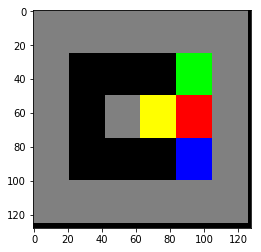

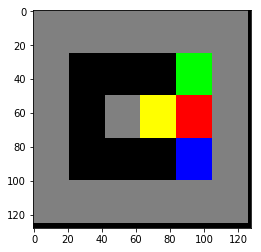

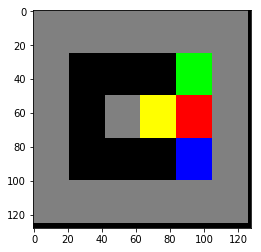

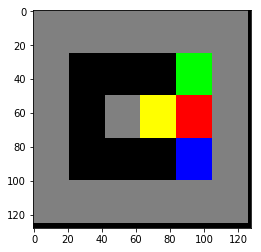

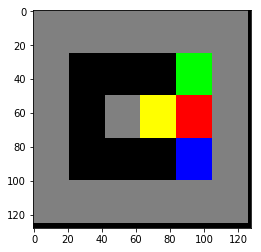

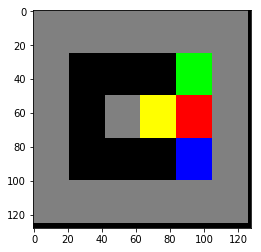

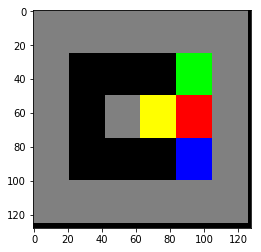

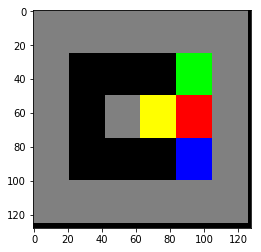

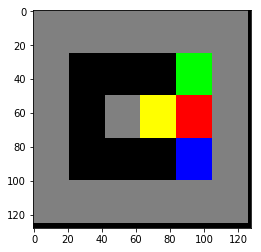

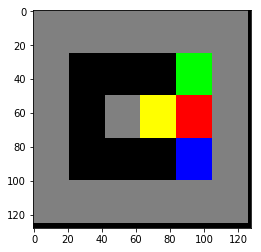

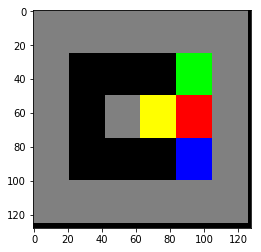

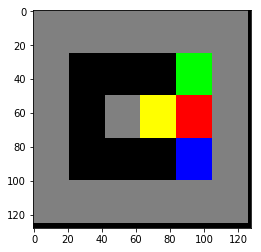

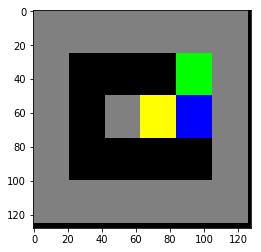

num_iter=13	DONE    	rsum=-1.012


(-1.012, 13, True)

In [24]:

params = {
#'precision' : 0.01,
'alpha'   : .01,
'alpha_R' : .01,
'gamma'   : .9999,
'eps'     : .1,
'k' : 10,
'default_Q' : .1,
}
# agent = QLearningAgent(env.action_space, params, env_methods=env_methods)
agent =     SARSAAgent(env.action_space, params, env_methods=env_methods)
# agent =     DynaQAgent(env.action_space, params, env_methods=env_methods)

out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=10000)
play_one_run(agent, env, verbose=2)


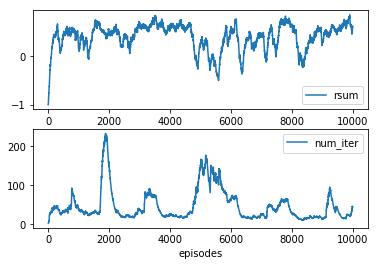

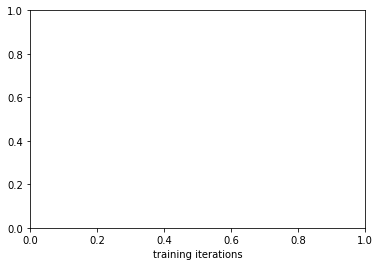

In [25]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
#     print(val_dict[k])
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.99), label=k)
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
keys = agent.log_dict.keys()
val_dict = agent.log_dict
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
plt.xlabel("training iterations")
plt.show()


eps = 0.1
default_Q = 0.1
alpha = 0.01
gamma = 0.9999
Episode 1	num_iter=6	DONE    	rsum=-1.005
Episode 2	num_iter=500	MAX_ITER	rsum=0.5009999999999997
Episode 3	num_iter=15	DONE    	rsum=-1.014
Episode 4	num_iter=3	DONE    	rsum=-1.002
Episode 5	num_iter=3	DONE    	rsum=-1.002
Episode 6	num_iter=1	DONE    	rsum=-1
Episode 7	num_iter=3	DONE    	rsum=-1.002
Episode 8	num_iter=1	DONE    	rsum=-1
Episode 9	num_iter=1	DONE    	rsum=-1
Episode 10	num_iter=1	DONE    	rsum=-1
Episode 11	num_iter=1	DONE    	rsum=-1
Episode 12	num_iter=1	DONE    	rsum=-1
Episode 13	num_iter=1	DONE    	rsum=-1
Episode 14	num_iter=1	DONE    	rsum=-1
Episode 15	num_iter=1	DONE    	rsum=-1
Episode 16	num_iter=1	DONE    	rsum=-1
Episode 17	num_iter=1	DONE    	rsum=-1
Episode 18	num_iter=1	DONE    	rsum=-1
Episode 19	num_iter=1	DONE    	rsum=-1
Episode 20	num_iter=10	DONE    	rsum=-1.009
Episode 21	num_iter=1	DONE    	rsum=-1
Episode 22	num_iter=1	DONE    	rsum=-1
Episode 23	num_iter=1	DONE    	rsum=-1
Episode 24	num

Episode 417	num_iter=33	DONE    	rsum=-1.032
Episode 418	num_iter=12	DONE    	rsum=-1.011
Episode 419	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 420	num_iter=10	DONE    	rsum=-1.009
Episode 421	num_iter=1	DONE    	rsum=-1
Episode 422	num_iter=1	DONE    	rsum=-1
Episode 423	num_iter=1	DONE    	rsum=-1
Episode 424	num_iter=1	DONE    	rsum=-1
Episode 425	num_iter=8	DONE    	rsum=-1.007
Episode 426	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 427	num_iter=22	DONE    	rsum=-1.021
Episode 428	num_iter=1	DONE    	rsum=-1
Episode 429	num_iter=1	DONE    	rsum=-1
Episode 430	num_iter=1	DONE    	rsum=-1
Episode 431	num_iter=1	DONE    	rsum=-1
Episode 432	num_iter=1	DONE    	rsum=-1
Episode 433	num_iter=1	DONE    	rsum=-1
Episode 434	num_iter=1	DONE    	rsum=-1
Episode 435	num_iter=1	DONE    	rsum=-1
Episode 436	num_iter=1	DONE    	rsum=-1
Episode 437	num_iter=1	DONE    	rsum=-1
Episode 438	num_iter=75	DONE    	rsum=-0.07300000000000006
Episode 439	num_iter=15	DONE    	rsum

Episode 627	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 628	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 629	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 630	num_iter=1	DONE    	rsum=-1
Episode 631	num_iter=3	DONE    	rsum=-1.002
Episode 632	num_iter=1	DONE    	rsum=-1
Episode 633	num_iter=1	DONE    	rsum=-1
Episode 634	num_iter=1	DONE    	rsum=-1
Episode 635	num_iter=1	DONE    	rsum=-1
Episode 636	num_iter=1	DONE    	rsum=-1
Episode 637	num_iter=1	DONE    	rsum=-1
Episode 638	num_iter=1	DONE    	rsum=-1
Episode 639	num_iter=1	DONE    	rsum=-1
Episode 640	num_iter=1	DONE    	rsum=-1
Episode 641	num_iter=1	DONE    	rsum=-1
Episode 642	num_iter=4	DONE    	rsum=-1.003
Episode 643	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 644	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 645	num_iter=11	DONE    	rsum=-1.01
Episode 646	num_iter=5	DONE    	rsum=-1.004
Episode 647	num_iter=1	DONE    	rsum=-1
Episode 648	num_iter=1	DONE    	rsum=-1
Episo

Episode 863	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 864	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 865	num_iter=3	DONE    	rsum=-1.002
Episode 866	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 867	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 868	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 869	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 870	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 871	num_iter=7	DONE    	rsum=-1.006
Episode 872	num_iter=250	DONE    	rsum=-0.24800000000000022
Episode 873	num_iter=5	DONE    	rsum=-1.004
Episode 874	num_iter=1	DONE    	rsum=-1
Episode 875	num_iter=1	DONE    	rsum=-1
Episode 876	num_iter=1	DONE    	rsum=-1
Episode 877	num_iter=1	DONE    	rsum=-1
Episode 878	num_iter=1	DONE    	rsum=-1
Episode 879	num_iter=1	DONE    	rsum=-1
Episode 880	num_iter=1	DONE    	rsum=-1
Episode 881	num_iter=1	DONE    	rsum=-1
Episode 882	num_iter=1	DONE    	rsum=-1
Episode 883	num_iter=1	DONE  

Episode 1036	num_iter=101	DONE    	rsum=-0.09900000000000009
Episode 1037	num_iter=4	DONE    	rsum=1.998
Episode 1038	num_iter=7	DONE    	rsum=1.995
Episode 1039	num_iter=4	DONE    	rsum=1.998
Episode 1040	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 1041	num_iter=40	DONE    	rsum=-0.038000000000000034
Episode 1042	num_iter=128	DONE    	rsum=-0.1260000000000001
Episode 1043	num_iter=6	DONE    	rsum=1.996
Episode 1044	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 1045	num_iter=3	DONE    	rsum=-1.002
Episode 1046	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 1047	num_iter=2	DONE    	rsum=-1.001
Episode 1048	num_iter=1	DONE    	rsum=-1
Episode 1049	num_iter=1	DONE    	rsum=-1
Episode 1050	num_iter=1	DONE    	rsum=-1
Episode 1051	num_iter=1	DONE    	rsum=-1
Episode 1052	num_iter=1	DONE    	rsum=-1
Episode 1053	num_iter=1	DONE    	rsum=-1
Episode 1054	num_iter=1	DONE    	rsum=-1
Episode 1055	num_iter=1	DONE    	rsum=-1
Episode 1056	num_iter=1	DONE    	rsum=-1
E

Episode 1226	num_iter=8	DONE    	rsum=1.994
Episode 1227	num_iter=2	DONE    	rsum=-1.001
Episode 1228	num_iter=1	DONE    	rsum=-1
Episode 1229	num_iter=1	DONE    	rsum=-1
Episode 1230	num_iter=1	DONE    	rsum=-1
Episode 1231	num_iter=1	DONE    	rsum=-1
Episode 1232	num_iter=3	DONE    	rsum=-1.002
Episode 1233	num_iter=1	DONE    	rsum=-1
Episode 1234	num_iter=3	DONE    	rsum=-1.002
Episode 1235	num_iter=1	DONE    	rsum=-1
Episode 1236	num_iter=26	DONE    	rsum=-1.025
Episode 1237	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 1238	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 1239	num_iter=1	DONE    	rsum=-1
Episode 1240	num_iter=19	DONE    	rsum=-1.018
Episode 1241	num_iter=3	DONE    	rsum=-1.002
Episode 1242	num_iter=4	DONE    	rsum=-1.003
Episode 1243	num_iter=2	DONE    	rsum=-1.001
Episode 1244	num_iter=7	DONE    	rsum=-1.006
Episode 1245	num_iter=6	DONE    	rsum=-1.005
Episode 1246	num_iter=1	DONE    	rsum=-1
Episode 1247	num_iter=1	DONE    	rsum=-1
Episode 1248	

Episode 1662	num_iter=279	DONE    	rsum=-0.27700000000000014
Episode 1663	num_iter=11	DONE    	rsum=-1.01
Episode 1664	num_iter=1	DONE    	rsum=-1
Episode 1665	num_iter=1	DONE    	rsum=-1
Episode 1666	num_iter=1	DONE    	rsum=-1
Episode 1667	num_iter=1	DONE    	rsum=-1
Episode 1668	num_iter=1	DONE    	rsum=-1
Episode 1669	num_iter=1	DONE    	rsum=-1
Episode 1670	num_iter=1	DONE    	rsum=-1
Episode 1671	num_iter=1	DONE    	rsum=-1
Episode 1672	num_iter=1	DONE    	rsum=-1
Episode 1673	num_iter=1	DONE    	rsum=-1
Episode 1674	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 1675	num_iter=1	DONE    	rsum=-1
Episode 1676	num_iter=3	DONE    	rsum=-1.002
Episode 1677	num_iter=4	DONE    	rsum=-1.003
Episode 1678	num_iter=1	DONE    	rsum=-1
Episode 1679	num_iter=3	DONE    	rsum=-1.002
Episode 1680	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 1681	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 1682	num_iter=3	DONE    	rsum=-1.002
Episode 1683	num_iter=11	DONE    	rsum=

Episode 1943	num_iter=500	MAX_ITER	rsum=-0.5000000000000003
Episode 1944	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 1945	num_iter=1	DONE    	rsum=-1
Episode 1946	num_iter=12	DONE    	rsum=-1.011
Episode 1947	num_iter=7	DONE    	rsum=-1.006
Episode 1948	num_iter=1	DONE    	rsum=-1
Episode 1949	num_iter=6	DONE    	rsum=-1.005
Episode 1950	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 1951	num_iter=19	DONE    	rsum=-1.018
Episode 1952	num_iter=7	DONE    	rsum=-1.006
Episode 1953	num_iter=7	DONE    	rsum=-1.006
Episode 1954	num_iter=9	DONE    	rsum=-1.008
Episode 1955	num_iter=1	DONE    	rsum=-1
Episode 1956	num_iter=1	DONE    	rsum=-1
Episode 1957	num_iter=1	DONE    	rsum=-1
Episode 1958	num_iter=1	DONE    	rsum=-1
Episode 1959	num_iter=4	DONE    	rsum=-1.003
Episode 1960	num_iter=1	DONE    	rsum=-1
Episode 1961	num_iter=1	DONE    	rsum=-1
Episode 1962	num_iter=33	DONE    	rsum=-1.032
Episode 1963	num_iter=1	DONE    	rsum=-1
Episode 1964	num_iter=1	DONE    	rsum=-1
Ep

Episode 2380	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 2381	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 2382	num_iter=10	DONE    	rsum=-1.009
Episode 2383	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 2384	num_iter=23	DONE    	rsum=-0.02100000000000002
Episode 2385	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 2386	num_iter=9	DONE    	rsum=-1.008
Episode 2387	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 2388	num_iter=6	DONE    	rsum=-1.005
Episode 2389	num_iter=1	DONE    	rsum=-1
Episode 2390	num_iter=1	DONE    	rsum=-1
Episode 2391	num_iter=1	DONE    	rsum=-1
Episode 2392	num_iter=1	DONE    	rsum=-1
Episode 2393	num_iter=1	DONE    	rsum=-1
Episode 2394	num_iter=1	DONE    	rsum=-1
Episode 2395	num_iter=1	DONE    	rsum=-1
Episode 2396	num_iter=1	DONE    	rsum=-1
Episode 2397	num_iter=1	DONE    	rsum=-1
Episode 2398	num_iter=1	DONE    	rsum=-1
Episode 2399	num_iter=1	DONE    	rsum=-1
Episode 2400	num_iter=1	DONE    	rsum=-1
Episode

Episode 2748	num_iter=1	DONE    	rsum=-1
Episode 2749	num_iter=1	DONE    	rsum=-1
Episode 2750	num_iter=1	DONE    	rsum=-1
Episode 2751	num_iter=1	DONE    	rsum=-1
Episode 2752	num_iter=1	DONE    	rsum=-1
Episode 2753	num_iter=1	DONE    	rsum=-1
Episode 2754	num_iter=8	DONE    	rsum=-1.007
Episode 2755	num_iter=1	DONE    	rsum=-1
Episode 2756	num_iter=4	DONE    	rsum=-1.003
Episode 2757	num_iter=1	DONE    	rsum=-1
Episode 2758	num_iter=1	DONE    	rsum=-1
Episode 2759	num_iter=1	DONE    	rsum=-1
Episode 2760	num_iter=1	DONE    	rsum=-1
Episode 2761	num_iter=1	DONE    	rsum=-1
Episode 2762	num_iter=1	DONE    	rsum=-1
Episode 2763	num_iter=1	DONE    	rsum=-1
Episode 2764	num_iter=1	DONE    	rsum=-1
Episode 2765	num_iter=3	DONE    	rsum=-1.002
Episode 2766	num_iter=1	DONE    	rsum=-1
Episode 2767	num_iter=1	DONE    	rsum=-1
Episode 2768	num_iter=1	DONE    	rsum=-1
Episode 2769	num_iter=3	DONE    	rsum=-1.002
Episode 2770	num_iter=1	DONE    	rsum=-1
Episode 2771	num_iter=1	DONE    	rsum=-1


Episode 3240	num_iter=175	DONE    	rsum=0.8259999999999998
Episode 3241	num_iter=20	DONE    	rsum=-1.019
Episode 3242	num_iter=3	DONE    	rsum=-1.002
Episode 3243	num_iter=1	DONE    	rsum=-1
Episode 3244	num_iter=1	DONE    	rsum=-1
Episode 3245	num_iter=1	DONE    	rsum=-1
Episode 3246	num_iter=1	DONE    	rsum=-1
Episode 3247	num_iter=1	DONE    	rsum=-1
Episode 3248	num_iter=10	DONE    	rsum=-1.009
Episode 3249	num_iter=1	DONE    	rsum=-1
Episode 3250	num_iter=1	DONE    	rsum=-1
Episode 3251	num_iter=1	DONE    	rsum=-1
Episode 3252	num_iter=1	DONE    	rsum=-1
Episode 3253	num_iter=1	DONE    	rsum=-1
Episode 3254	num_iter=5	DONE    	rsum=-1.004
Episode 3255	num_iter=5	DONE    	rsum=-1.004
Episode 3256	num_iter=1	DONE    	rsum=-1
Episode 3257	num_iter=1	DONE    	rsum=-1
Episode 3258	num_iter=1	DONE    	rsum=-1
Episode 3259	num_iter=7	DONE    	rsum=-1.006
Episode 3260	num_iter=1	DONE    	rsum=-1
Episode 3261	num_iter=1	DONE    	rsum=-1
Episode 3262	num_iter=1	DONE    	rsum=-1
Episode 3263	

Episode 3561	num_iter=246	DONE    	rsum=-0.24400000000000022
Episode 3562	num_iter=500	MAX_ITER	rsum=-0.5000000000000003
Episode 3563	num_iter=16	DONE    	rsum=-1.015
Episode 3564	num_iter=5	DONE    	rsum=-1.004
Episode 3565	num_iter=12	DONE    	rsum=-1.011
Episode 3566	num_iter=3	DONE    	rsum=-1.002
Episode 3567	num_iter=9	DONE    	rsum=-1.008
Episode 3568	num_iter=6	DONE    	rsum=-1.005
Episode 3569	num_iter=16	DONE    	rsum=-1.015
Episode 3570	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 3571	num_iter=1	DONE    	rsum=-1
Episode 3572	num_iter=1	DONE    	rsum=-1
Episode 3573	num_iter=1	DONE    	rsum=-1
Episode 3574	num_iter=3	DONE    	rsum=-1.002
Episode 3575	num_iter=7	DONE    	rsum=-1.006
Episode 3576	num_iter=1	DONE    	rsum=-1
Episode 3577	num_iter=1	DONE    	rsum=-1
Episode 3578	num_iter=1	DONE    	rsum=-1
Episode 3579	num_iter=3	DONE    	rsum=-1.002
Episode 3580	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 3581	num_iter=5	DONE    	rsum=-1.004
Episode 3582	

Episode 3869	num_iter=20	DONE    	rsum=-1.019
Episode 3870	num_iter=246	DONE    	rsum=-0.24400000000000022
Episode 3871	num_iter=3	DONE    	rsum=-1.002
Episode 3872	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 3873	num_iter=7	DONE    	rsum=-1.006
Episode 3874	num_iter=12	DONE    	rsum=-1.011
Episode 3875	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 3876	num_iter=11	DONE    	rsum=-1.01
Episode 3877	num_iter=7	DONE    	rsum=-1.006
Episode 3878	num_iter=1	DONE    	rsum=-1
Episode 3879	num_iter=1	DONE    	rsum=-1
Episode 3880	num_iter=7	DONE    	rsum=-1.006
Episode 3881	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 3882	num_iter=13	DONE    	rsum=-1.012
Episode 3883	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 3884	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 3885	num_iter=8	DONE    	rsum=-1.007
Episode 3886	num_iter=1	DONE    	rsum=-1
Episode 3887	num_iter=1	DONE    	rsum=-1
Episode 3888	num_iter=1	DONE    	rsum=-1
Episode 3889	num_iter

Episode 4131	num_iter=500	MAX_ITER	rsum=-0.5000000000000003
Episode 4132	num_iter=1	DONE    	rsum=-1
Episode 4133	num_iter=12	DONE    	rsum=-1.011
Episode 4134	num_iter=1	DONE    	rsum=-1
Episode 4135	num_iter=1	DONE    	rsum=-1
Episode 4136	num_iter=7	DONE    	rsum=-1.006
Episode 4137	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 4138	num_iter=5	DONE    	rsum=-1.004
Episode 4139	num_iter=25	DONE    	rsum=-0.02300000000000002
Episode 4140	num_iter=3	DONE    	rsum=-1.002
Episode 4141	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4142	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4143	num_iter=21	DONE    	rsum=-1.02
Episode 4144	num_iter=2	DONE    	rsum=-1.001
Episode 4145	num_iter=1	DONE    	rsum=-1
Episode 4146	num_iter=1	DONE    	rsum=-1
Episode 4147	num_iter=1	DONE    	rsum=-1
Episode 4148	num_iter=1	DONE    	rsum=-1
Episode 4149	num_iter=1	DONE    	rsum=-1
Episode 4150	num_iter=1	DONE    	rsum=-1
Episode 4151	num_iter=1	DONE    	rsum=-1
Episode 4152	num

Episode 4378	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 4379	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 4380	num_iter=9	DONE    	rsum=-1.008
Episode 4381	num_iter=5	DONE    	rsum=-1.004
Episode 4382	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4383	num_iter=9	DONE    	rsum=-1.008
Episode 4384	num_iter=1	DONE    	rsum=-1
Episode 4385	num_iter=1	DONE    	rsum=-1
Episode 4386	num_iter=10	DONE    	rsum=-1.009
Episode 4387	num_iter=1	DONE    	rsum=-1
Episode 4388	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 4389	num_iter=2	DONE    	rsum=-1.001
Episode 4390	num_iter=1	DONE    	rsum=-1
Episode 4391	num_iter=1	DONE    	rsum=-1
Episode 4392	num_iter=3	DONE    	rsum=-1.002
Episode 4393	num_iter=1	DONE    	rsum=-1
Episode 4394	num_iter=14	DONE    	rsum=-1.013
Episode 4395	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 4396	num_iter=5	DONE    	rsum=-1.004
Episode 4397	num_iter=12	DONE    	rsum=-1.011
Episode 4398	num_iter=5	DONE    	rsum=-1.

Episode 4673	num_iter=1	DONE    	rsum=-1
Episode 4674	num_iter=1	DONE    	rsum=-1
Episode 4675	num_iter=1	DONE    	rsum=-1
Episode 4676	num_iter=1	DONE    	rsum=-1
Episode 4677	num_iter=1	DONE    	rsum=-1
Episode 4678	num_iter=1	DONE    	rsum=-1
Episode 4679	num_iter=1	DONE    	rsum=-1
Episode 4680	num_iter=3	DONE    	rsum=-1.002
Episode 4681	num_iter=1	DONE    	rsum=-1
Episode 4682	num_iter=1	DONE    	rsum=-1
Episode 4683	num_iter=1	DONE    	rsum=-1
Episode 4684	num_iter=1	DONE    	rsum=-1
Episode 4685	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4686	num_iter=1	DONE    	rsum=-1
Episode 4687	num_iter=1	DONE    	rsum=-1
Episode 4688	num_iter=3	DONE    	rsum=-1.002
Episode 4689	num_iter=1	DONE    	rsum=-1
Episode 4690	num_iter=1	DONE    	rsum=-1
Episode 4691	num_iter=1	DONE    	rsum=-1
Episode 4692	num_iter=1	DONE    	rsum=-1
Episode 4693	num_iter=1	DONE    	rsum=-1
Episode 4694	num_iter=4	DONE    	rsum=-1.003
Episode 4695	num_iter=1	DONE    	rsum=-1
Episode 4696	num_iter=4	D

Episode 4950	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 4951	num_iter=3	DONE    	rsum=-1.002
Episode 4952	num_iter=1	DONE    	rsum=-1
Episode 4953	num_iter=15	DONE    	rsum=-0.013000000000000012
Episode 4954	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4955	num_iter=2	DONE    	rsum=-1.001
Episode 4956	num_iter=1	DONE    	rsum=-1
Episode 4957	num_iter=4	DONE    	rsum=-1.003
Episode 4958	num_iter=3	DONE    	rsum=-1.002
Episode 4959	num_iter=1	DONE    	rsum=-1
Episode 4960	num_iter=1	DONE    	rsum=-1
Episode 4961	num_iter=1	DONE    	rsum=-1
Episode 4962	num_iter=6	DONE    	rsum=-1.005
Episode 4963	num_iter=1	DONE    	rsum=-1
Episode 4964	num_iter=1	DONE    	rsum=-1
Episode 4965	num_iter=1	DONE    	rsum=-1
Episode 4966	num_iter=1	DONE    	rsum=-1
Episode 4967	num_iter=1	DONE    	rsum=-1
Episode 4968	num_iter=21	DONE    	rsum=-1.02
Episode 4969	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 4970	num_iter=7	DONE    	rsum=-1.006
Episode 4971	num_iter=1	DONE   

Episode 5131	num_iter=117	DONE    	rsum=-0.1150000000000001
Episode 5132	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5133	num_iter=1	DONE    	rsum=-1
Episode 5134	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5135	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5136	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5137	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5138	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5139	num_iter=1	DONE    	rsum=-1
Episode 5140	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 5141	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5142	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 5143	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5144	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 5145	num_iter=1	DONE    	rsum=-1
Episode 5146	num_iter=32	DONE    	rsum=-0.030000000000000027
Episode 5147	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5148	num_iter=5	

Episode 5307	num_iter=141	DONE    	rsum=1.8609999999999998
Episode 5308	num_iter=79	DONE    	rsum=-0.07700000000000007
Episode 5309	num_iter=29	DONE    	rsum=-0.027000000000000024
Episode 5310	num_iter=12	DONE    	rsum=1.99
Episode 5311	num_iter=131	DONE    	rsum=-0.12900000000000011
Episode 5312	num_iter=221	DONE    	rsum=-0.2190000000000002
Episode 5313	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5314	num_iter=168	DONE    	rsum=-0.16600000000000015
Episode 5315	num_iter=448	DONE    	rsum=1.5539999999999996
Episode 5316	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 5317	num_iter=27	DONE    	rsum=-0.025000000000000022
Episode 5318	num_iter=145	DONE    	rsum=-0.14300000000000013
Episode 5319	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5320	num_iter=1	DONE    	rsum=-1
Episode 5321	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 5322	num_iter=136	DONE    	rsum=1.8659999999999999
Episode 5323	num_iter=1	DONE    	rsum=-1
Episode 5324	num_iter=6	DONE  

Episode 5505	num_iter=405	DONE    	rsum=-0.40300000000000036
Episode 5506	num_iter=1	DONE    	rsum=-1
Episode 5507	num_iter=7	DONE    	rsum=1.995
Episode 5508	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 5509	num_iter=253	DONE    	rsum=1.7489999999999997
Episode 5510	num_iter=4	DONE    	rsum=1.998
Episode 5511	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 5512	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 5513	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5514	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 5515	num_iter=6	DONE    	rsum=1.996
Episode 5516	num_iter=9	DONE    	rsum=1.9929999999999999
Episode 5517	num_iter=1	DONE    	rsum=-1
Episode 5518	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5519	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5520	num_iter=131	DONE    	rsum=1.871
Episode 5521	num_iter=94	DONE    	rsum=-0.09200000000000008
Episode 5522	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5523	num_iter

Episode 5687	num_iter=203	DONE    	rsum=-0.20100000000000018
Episode 5688	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 5689	num_iter=500	MAX_ITER	rsum=-0.49800000000000044
Episode 5690	num_iter=38	DONE    	rsum=1.964
Episode 5691	num_iter=31	DONE    	rsum=1.971
Episode 5692	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5693	num_iter=28	DONE    	rsum=1.974
Episode 5694	num_iter=1	DONE    	rsum=-1
Episode 5695	num_iter=7	DONE    	rsum=-0.0050000000000000044
Episode 5696	num_iter=98	DONE    	rsum=-0.09600000000000009
Episode 5697	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5698	num_iter=4	DONE    	rsum=1.998
Episode 5699	num_iter=4	DONE    	rsum=1.998
Episode 5700	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5701	num_iter=190	DONE    	rsum=-0.18800000000000017
Episode 5702	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 5703	num_iter=4	DONE    	rsum=1.998
Episode 5704	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 5705	num_iter=13	

Episode 5845	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5846	num_iter=3	DONE    	rsum=-1.002
Episode 5847	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5848	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5849	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5850	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5851	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5852	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5853	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5854	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5855	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5856	num_iter=124	DONE    	rsum=-0.12200000000000011
Episode 5857	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 5858	num_iter=2	DONE    	rsum=-1.001
Episode 5859	num_iter=1	DONE    	rsum=-1
Episode 5860	num_iter=1	DONE    	rsum=-1
Episode 5861	num_iter=1	DONE    	rsum=-1
Episode 5862	num_iter=1	DONE    	rsum=-1
Episode 5863	num_iter=500	MAX_ITER	r

Episode 6060	num_iter=123	DONE    	rsum=1.879
Episode 6061	num_iter=4	DONE    	rsum=1.998
Episode 6062	num_iter=4	DONE    	rsum=1.998
Episode 6063	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 6064	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 6065	num_iter=13	DONE    	rsum=1.9889999999999999
Episode 6066	num_iter=4	DONE    	rsum=1.998
Episode 6067	num_iter=4	DONE    	rsum=1.998
Episode 6068	num_iter=4	DONE    	rsum=1.998
Episode 6069	num_iter=134	DONE    	rsum=1.8679999999999999
Episode 6070	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 6071	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 6072	num_iter=4	DONE    	rsum=1.998
Episode 6073	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 6074	num_iter=221	DONE    	rsum=1.7809999999999997
Episode 6075	num_iter=4	DONE    	rsum=1.998
Episode 6076	num_iter=6	DONE    	rsum=1.996
Episode 6077	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 6078	num_iter=4	DONE    	rsum=1.998
Episode 6079	num_iter=6	

Episode 6389	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 6390	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 6391	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 6392	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 6393	num_iter=1	DONE    	rsum=-1
Episode 6394	num_iter=341	DONE    	rsum=1.6609999999999996
Episode 6395	num_iter=155	DONE    	rsum=1.847
Episode 6396	num_iter=4	DONE    	rsum=1.998
Episode 6397	num_iter=4	DONE    	rsum=1.998
Episode 6398	num_iter=4	DONE    	rsum=1.998
Episode 6399	num_iter=197	DONE    	rsum=1.8049999999999997
Episode 6400	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 6401	num_iter=4	DONE    	rsum=1.998
Episode 6402	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 6403	num_iter=328	DONE    	rsum=1.6739999999999997
Episode 6404	num_iter=4	DONE    	rsum=1.998
Episode 6405	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 6406	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 6407	num_iter=3	DONE    	rsum=

Episode 6620	num_iter=8	DONE    	rsum=1.994
Episode 6621	num_iter=4	DONE    	rsum=1.998
Episode 6622	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 6623	num_iter=4	DONE    	rsum=1.998
Episode 6624	num_iter=48	DONE    	rsum=1.954
Episode 6625	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 6626	num_iter=226	DONE    	rsum=0.7749999999999998
Episode 6627	num_iter=128	DONE    	rsum=1.8739999999999999
Episode 6628	num_iter=8	DONE    	rsum=1.994
Episode 6629	num_iter=1	DONE    	rsum=-1
Episode 6630	num_iter=7	DONE    	rsum=-1.006
Episode 6631	num_iter=4	DONE    	rsum=1.998
Episode 6632	num_iter=1	DONE    	rsum=-1
Episode 6633	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 6634	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 6635	num_iter=1	DONE    	rsum=-1
Episode 6636	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 6637	num_iter=4	DONE    	rsum=1.998
Episode 6638	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 6639	num_iter=2	DONE    	rsum=-1.001
Ep

Episode 6836	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 6837	num_iter=247	DONE    	rsum=1.755
Episode 6838	num_iter=4	DONE    	rsum=1.998
Episode 6839	num_iter=4	DONE    	rsum=1.998
Episode 6840	num_iter=4	DONE    	rsum=1.998
Episode 6841	num_iter=4	DONE    	rsum=1.998
Episode 6842	num_iter=2	DONE    	rsum=-1.001
Episode 6843	num_iter=1	DONE    	rsum=-1
Episode 6844	num_iter=1	DONE    	rsum=-1
Episode 6845	num_iter=1	DONE    	rsum=-1
Episode 6846	num_iter=1	DONE    	rsum=-1
Episode 6847	num_iter=1	DONE    	rsum=-1
Episode 6848	num_iter=1	DONE    	rsum=-1
Episode 6849	num_iter=1	DONE    	rsum=-1
Episode 6850	num_iter=1	DONE    	rsum=-1
Episode 6851	num_iter=1	DONE    	rsum=-1
Episode 6852	num_iter=3	DONE    	rsum=-1.002
Episode 6853	num_iter=1	DONE    	rsum=-1
Episode 6854	num_iter=4	DONE    	rsum=1.998
Episode 6855	num_iter=4	DONE    	rsum=1.998
Episode 6856	num_iter=4	DONE    	rsum=1.998
Episode 6857	num_iter=6	DONE    	rsum=1.996
Episode 6858	num_iter=4	DONE    	rsum=1.9

Episode 7013	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 7014	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 7015	num_iter=183	DONE    	rsum=1.819
Episode 7016	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 7017	num_iter=1	DONE    	rsum=-1
Episode 7018	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7019	num_iter=1	DONE    	rsum=-1
Episode 7020	num_iter=3	DONE    	rsum=-1.002
Episode 7021	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 7022	num_iter=363	DONE    	rsum=1.6389999999999998
Episode 7023	num_iter=4	DONE    	rsum=1.998
Episode 7024	num_iter=4	DONE    	rsum=1.998
Episode 7025	num_iter=4	DONE    	rsum=1.998
Episode 7026	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 7027	num_iter=3	DONE    	rsum=-1.002
Episode 7028	num_iter=4	DONE    	rsum=1.998
Episode 7029	num_iter=6	DONE    	rsum=1.996
Episode 7030	num_iter=4	DONE    	rsum=1.998
Episode 7031	num_iter=4	DONE    	rsum=1.998
Episode 7032	num_iter=4	DONE    	rsum=1.998
Episode 7033	num_iter

Episode 7194	num_iter=4	DONE    	rsum=1.998
Episode 7195	num_iter=164	DONE    	rsum=1.8379999999999999
Episode 7196	num_iter=4	DONE    	rsum=1.998
Episode 7197	num_iter=228	DONE    	rsum=-0.2260000000000002
Episode 7198	num_iter=4	DONE    	rsum=1.998
Episode 7199	num_iter=4	DONE    	rsum=-1.003
Episode 7200	num_iter=1	DONE    	rsum=-1
Episode 7201	num_iter=1	DONE    	rsum=-1
Episode 7202	num_iter=1	DONE    	rsum=-1
Episode 7203	num_iter=1	DONE    	rsum=-1
Episode 7204	num_iter=4	DONE    	rsum=-1.003
Episode 7205	num_iter=1	DONE    	rsum=-1
Episode 7206	num_iter=1	DONE    	rsum=-1
Episode 7207	num_iter=1	DONE    	rsum=-1
Episode 7208	num_iter=1	DONE    	rsum=-1
Episode 7209	num_iter=1	DONE    	rsum=-1
Episode 7210	num_iter=7	DONE    	rsum=-1.006
Episode 7211	num_iter=4	DONE    	rsum=-1.003
Episode 7212	num_iter=1	DONE    	rsum=-1
Episode 7213	num_iter=6	DONE    	rsum=-1.005
Episode 7214	num_iter=13	DONE    	rsum=-1.012
Episode 7215	num_iter=8	DONE    	rsum=1.994
Episode 7216	num_iter=1	

Episode 7391	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 7392	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 7393	num_iter=174	DONE    	rsum=1.8279999999999998
Episode 7394	num_iter=73	DONE    	rsum=1.9289999999999998
Episode 7395	num_iter=6	DONE    	rsum=1.996
Episode 7396	num_iter=433	DONE    	rsum=1.5689999999999995
Episode 7397	num_iter=14	DONE    	rsum=1.988
Episode 7398	num_iter=4	DONE    	rsum=1.998
Episode 7399	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 7400	num_iter=226	DONE    	rsum=1.7759999999999998
Episode 7401	num_iter=63	DONE    	rsum=1.939
Episode 7402	num_iter=4	DONE    	rsum=1.998
Episode 7403	num_iter=4	DONE    	rsum=1.998
Episode 7404	num_iter=4	DONE    	rsum=1.998
Episode 7405	num_iter=7	DONE    	rsum=1.995
Episode 7406	num_iter=4	DONE    	rsum=1.998
Episode 7407	num_iter=6	DONE    	rsum=1.996
Episode 7408	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 7409	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7410	num_iter=50

Episode 7565	num_iter=418	DONE    	rsum=1.5839999999999996
Episode 7566	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7567	num_iter=4	DONE    	rsum=1.998
Episode 7568	num_iter=1	DONE    	rsum=-1
Episode 7569	num_iter=1	DONE    	rsum=-1
Episode 7570	num_iter=110	DONE    	rsum=-0.1080000000000001
Episode 7571	num_iter=4	DONE    	rsum=1.998
Episode 7572	num_iter=4	DONE    	rsum=1.998
Episode 7573	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7574	num_iter=436	DONE    	rsum=1.5659999999999996
Episode 7575	num_iter=4	DONE    	rsum=1.998
Episode 7576	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 7577	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 7578	num_iter=4	DONE    	rsum=1.998
Episode 7579	num_iter=6	DONE    	rsum=1.996
Episode 7580	num_iter=4	DONE    	rsum=1.998
Episode 7581	num_iter=4	DONE    	rsum=1.998
Episode 7582	num_iter=1	DONE    	rsum=-1
Episode 7583	num_iter=3	DONE    	rsum=-1.002
Episode 7584	num_iter=6	DONE    	rsum=1.996
Episode 7585	num_iter=

Episode 7773	num_iter=150	DONE    	rsum=1.8519999999999999
Episode 7774	num_iter=7	DONE    	rsum=1.995
Episode 7775	num_iter=181	DONE    	rsum=1.8209999999999997
Episode 7776	num_iter=34	DONE    	rsum=1.968
Episode 7777	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 7778	num_iter=4	DONE    	rsum=1.998
Episode 7779	num_iter=1	DONE    	rsum=-1
Episode 7780	num_iter=50	DONE    	rsum=1.952
Episode 7781	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 7782	num_iter=4	DONE    	rsum=1.998
Episode 7783	num_iter=10	DONE    	rsum=1.992
Episode 7784	num_iter=4	DONE    	rsum=1.998
Episode 7785	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7786	num_iter=1	DONE    	rsum=-1
Episode 7787	num_iter=178	DONE    	rsum=1.8239999999999998
Episode 7788	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7789	num_iter=4	DONE    	rsum=1.998
Episode 7790	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 7791	num_iter=1	DONE    	rsum=-1
Episode 7792	num_iter=2	DONE    	rsum=-1.001
Epi

Episode 8081	num_iter=1	DONE    	rsum=-1
Episode 8082	num_iter=1	DONE    	rsum=-1
Episode 8083	num_iter=5	DONE    	rsum=-1.004
Episode 8084	num_iter=4	DONE    	rsum=-1.003
Episode 8085	num_iter=1	DONE    	rsum=-1
Episode 8086	num_iter=3	DONE    	rsum=-1.002
Episode 8087	num_iter=3	DONE    	rsum=-1.002
Episode 8088	num_iter=6	DONE    	rsum=-1.005
Episode 8089	num_iter=1	DONE    	rsum=-1
Episode 8090	num_iter=1	DONE    	rsum=-1
Episode 8091	num_iter=5	DONE    	rsum=-1.004
Episode 8092	num_iter=4	DONE    	rsum=-1.003
Episode 8093	num_iter=1	DONE    	rsum=-1
Episode 8094	num_iter=4	DONE    	rsum=-1.003
Episode 8095	num_iter=3	DONE    	rsum=-1.002
Episode 8096	num_iter=1	DONE    	rsum=-1
Episode 8097	num_iter=1	DONE    	rsum=-1
Episode 8098	num_iter=1	DONE    	rsum=-1
Episode 8099	num_iter=1	DONE    	rsum=-1
Episode 8100	num_iter=3	DONE    	rsum=-1.002
Episode 8101	num_iter=1	DONE    	rsum=-1
Episode 8102	num_iter=1	DONE    	rsum=-1
Episode 8103	num_iter=1	DONE    	rsum=-1
Episode 8104	num_

Episode 8377	num_iter=466	DONE    	rsum=1.5359999999999996
Episode 8378	num_iter=83	DONE    	rsum=1.919
Episode 8379	num_iter=1	DONE    	rsum=-1
Episode 8380	num_iter=5	DONE    	rsum=-1.004
Episode 8381	num_iter=1	DONE    	rsum=-1
Episode 8382	num_iter=12	DONE    	rsum=-1.011
Episode 8383	num_iter=1	DONE    	rsum=-1
Episode 8384	num_iter=1	DONE    	rsum=-1
Episode 8385	num_iter=1	DONE    	rsum=-1
Episode 8386	num_iter=1	DONE    	rsum=-1
Episode 8387	num_iter=1	DONE    	rsum=-1
Episode 8388	num_iter=1	DONE    	rsum=-1
Episode 8389	num_iter=17	DONE    	rsum=-1.016
Episode 8390	num_iter=8	DONE    	rsum=-1.007
Episode 8391	num_iter=1	DONE    	rsum=-1
Episode 8392	num_iter=1	DONE    	rsum=-1
Episode 8393	num_iter=3	DONE    	rsum=-1.002
Episode 8394	num_iter=1	DONE    	rsum=-1
Episode 8395	num_iter=1	DONE    	rsum=-1
Episode 8396	num_iter=24	DONE    	rsum=-1.023
Episode 8397	num_iter=1	DONE    	rsum=-1
Episode 8398	num_iter=1	DONE    	rsum=-1
Episode 8399	num_iter=1	DONE    	rsum=-1
Episode 

Episode 8766	num_iter=14	DONE    	rsum=1.988
Episode 8767	num_iter=12	DONE    	rsum=1.99
Episode 8768	num_iter=17	DONE    	rsum=-1.016
Episode 8769	num_iter=11	DONE    	rsum=-1.01
Episode 8770	num_iter=5	DONE    	rsum=-1.004
Episode 8771	num_iter=4	DONE    	rsum=1.998
Episode 8772	num_iter=8	DONE    	rsum=-1.007
Episode 8773	num_iter=3	DONE    	rsum=-1.002
Episode 8774	num_iter=1	DONE    	rsum=-1
Episode 8775	num_iter=1	DONE    	rsum=-1
Episode 8776	num_iter=1	DONE    	rsum=-1
Episode 8777	num_iter=1	DONE    	rsum=-1
Episode 8778	num_iter=12	DONE    	rsum=1.99
Episode 8779	num_iter=2	DONE    	rsum=-1.001
Episode 8780	num_iter=3	DONE    	rsum=-1.002
Episode 8781	num_iter=1	DONE    	rsum=-1
Episode 8782	num_iter=1	DONE    	rsum=-1
Episode 8783	num_iter=14	DONE    	rsum=1.988
Episode 8784	num_iter=12	DONE    	rsum=-1.011
Episode 8785	num_iter=1	DONE    	rsum=-1
Episode 8786	num_iter=1	DONE    	rsum=-1
Episode 8787	num_iter=1	DONE    	rsum=-1
Episode 8788	num_iter=3	DONE    	rsum=-1.002
Ep

Episode 9161	num_iter=417	DONE    	rsum=1.5849999999999995
Episode 9162	num_iter=8	DONE    	rsum=1.994
Episode 9163	num_iter=3	DONE    	rsum=-1.002
Episode 9164	num_iter=8	DONE    	rsum=1.994
Episode 9165	num_iter=2	DONE    	rsum=-1.001
Episode 9166	num_iter=1	DONE    	rsum=-1
Episode 9167	num_iter=1	DONE    	rsum=-1
Episode 9168	num_iter=1	DONE    	rsum=-1
Episode 9169	num_iter=1	DONE    	rsum=-1
Episode 9170	num_iter=90	DONE    	rsum=1.912
Episode 9171	num_iter=10	DONE    	rsum=-1.009
Episode 9172	num_iter=4	DONE    	rsum=-1.003
Episode 9173	num_iter=1	DONE    	rsum=-1
Episode 9174	num_iter=1	DONE    	rsum=-1
Episode 9175	num_iter=1	DONE    	rsum=-1
Episode 9176	num_iter=1	DONE    	rsum=-1
Episode 9177	num_iter=1	DONE    	rsum=-1
Episode 9178	num_iter=1	DONE    	rsum=-1
Episode 9179	num_iter=1	DONE    	rsum=-1
Episode 9180	num_iter=1	DONE    	rsum=-1
Episode 9181	num_iter=3	DONE    	rsum=-1.002
Episode 9182	num_iter=1	DONE    	rsum=-1
Episode 9183	num_iter=1	DONE    	rsum=-1
Episode 

Episode 9438	num_iter=89	DONE    	rsum=1.9129999999999998
Episode 9439	num_iter=6	DONE    	rsum=1.996
Episode 9440	num_iter=10	DONE    	rsum=-1.009
Episode 9441	num_iter=1	DONE    	rsum=-1
Episode 9442	num_iter=1	DONE    	rsum=-1
Episode 9443	num_iter=1	DONE    	rsum=-1
Episode 9444	num_iter=1	DONE    	rsum=-1
Episode 9445	num_iter=1	DONE    	rsum=-1
Episode 9446	num_iter=1	DONE    	rsum=-1
Episode 9447	num_iter=16	DONE    	rsum=-1.015
Episode 9448	num_iter=4	DONE    	rsum=1.998
Episode 9449	num_iter=15	DONE    	rsum=-1.014
Episode 9450	num_iter=2	DONE    	rsum=-1.001
Episode 9451	num_iter=1	DONE    	rsum=-1
Episode 9452	num_iter=1	DONE    	rsum=-1
Episode 9453	num_iter=1	DONE    	rsum=-1
Episode 9454	num_iter=1	DONE    	rsum=-1
Episode 9455	num_iter=1	DONE    	rsum=-1
Episode 9456	num_iter=1	DONE    	rsum=-1
Episode 9457	num_iter=1	DONE    	rsum=-1
Episode 9458	num_iter=1	DONE    	rsum=-1
Episode 9459	num_iter=1	DONE    	rsum=-1
Episode 9460	num_iter=1	DONE    	rsum=-1
Episode 9461	nu

Episode 9737	num_iter=6	DONE    	rsum=1.996
Episode 9738	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 9739	num_iter=6	DONE    	rsum=1.996
Episode 9740	num_iter=4	DONE    	rsum=1.998
Episode 9741	num_iter=4	DONE    	rsum=1.998
Episode 9742	num_iter=6	DONE    	rsum=1.996
Episode 9743	num_iter=4	DONE    	rsum=1.998
Episode 9744	num_iter=4	DONE    	rsum=1.998
Episode 9745	num_iter=10	DONE    	rsum=1.992
Episode 9746	num_iter=4	DONE    	rsum=1.998
Episode 9747	num_iter=4	DONE    	rsum=1.998
Episode 9748	num_iter=4	DONE    	rsum=1.998
Episode 9749	num_iter=3	DONE    	rsum=-0.0010000000000000009
Episode 9750	num_iter=4	DONE    	rsum=1.998
Episode 9751	num_iter=20	DONE    	rsum=1.982
Episode 9752	num_iter=4	DONE    	rsum=1.998
Episode 9753	num_iter=4	DONE    	rsum=1.998
Episode 9754	num_iter=4	DONE    	rsum=1.998
Episode 9755	num_iter=8	DONE    	rsum=1.994
Episode 9756	num_iter=4	DONE    	rsum=1.998
Episode 9757	num_iter=4	DONE    	rsum=1.998
Episode 9758	num_iter=500	MAX_ITER	rsum=0.50

Episode 9988	num_iter=177	DONE    	rsum=0.8239999999999998
Episode 9989	num_iter=4	DONE    	rsum=-1.003
Episode 9990	num_iter=7	DONE    	rsum=-1.006
Episode 9991	num_iter=147	DONE    	rsum=1.855
Episode 9992	num_iter=6	DONE    	rsum=-1.005
Episode 9993	num_iter=9	DONE    	rsum=-0.007000000000000006
Episode 9994	num_iter=84	DONE    	rsum=1.918
Episode 9995	num_iter=5	DONE    	rsum=1.9969999999999999
Episode 9996	num_iter=4	DONE    	rsum=-1.003
Episode 9997	num_iter=1	DONE    	rsum=-1
Episode 9998	num_iter=69	DONE    	rsum=1.9329999999999998
Episode 9999	num_iter=100	DONE    	rsum=1.902
Episode 10000	num_iter=76	DONE    	rsum=1.926


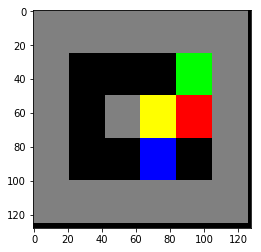

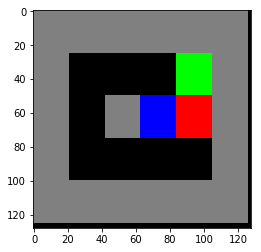

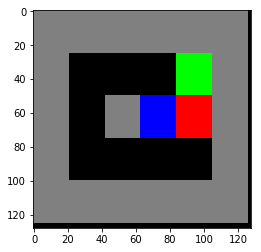

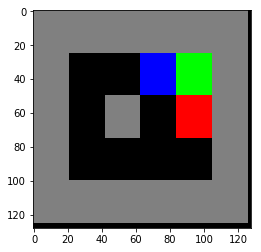

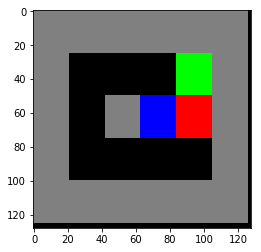

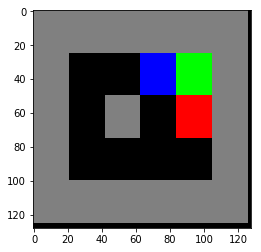

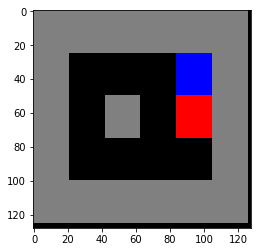

num_iter=7	DONE    	rsum=1.995


(1.995, 7, True)

In [15]:

params = {
#'precision' : 0.01,
'alpha'   : .01,
'alpha_R' : .01,
'gamma'   : .9999,
'eps'     : .1,
'k' : 10,
'default_Q' : .1,
}
agent = QLearningAgent(env.action_space, params, env_methods=env_methods)
# agent =     SARSAAgent(env.action_space, params, env_methods=env_methods)
# agent =     DynaQAgent(env.action_space, params, env_methods=env_methods)

out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=10000)
# play_one_run(agent, env, verbose=2)


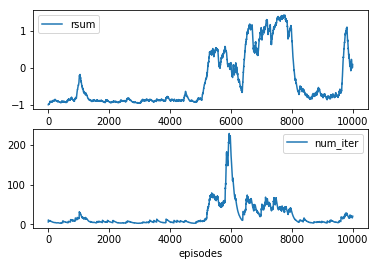

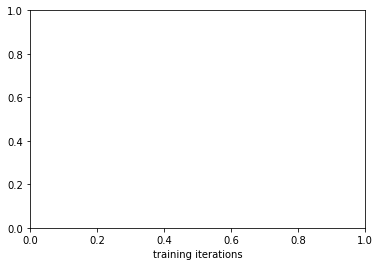

In [16]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
#     print(val_dict[k])
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.99), label=k)
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
keys = agent.log_dict.keys()
val_dict = agent.log_dict
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
plt.xlabel("training iterations")
plt.show()


In [26]:

params = {
#'precision' : 0.01,
'alpha'   : .01,
'alpha_R' : .001,
'gamma'   : .9999,
'eps'     : .1,
'k' : 10,
'default_Q' : .1,
}
# agent = QLearningAgent(env.action_space, params, env_methods=env_methods)
# agent =     SARSAAgent(env.action_space, params, env_methods=env_methods)
agent =     DynaQAgent(env.action_space, params, env_methods=env_methods)

out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=4000)
# play_one_run(agent, env, verbose=2)


eps = 0.1
default_Q = 0.1
alpha = 0.01
gamma = 0.9999
alpha_R = 0.001
k = 10
Episode 1	num_iter=2	DONE    	rsum=-1.001
Episode 2	num_iter=4	DONE    	rsum=-1.003
Episode 3	num_iter=1	DONE    	rsum=-1
Episode 4	num_iter=1	DONE    	rsum=-1
Episode 5	num_iter=1	DONE    	rsum=-1
Episode 6	num_iter=1	DONE    	rsum=-1
Episode 7	num_iter=2	DONE    	rsum=-1.001
Episode 8	num_iter=1	DONE    	rsum=-1
Episode 9	num_iter=1	DONE    	rsum=-1
Episode 10	num_iter=1	DONE    	rsum=-1
Episode 11	num_iter=1	DONE    	rsum=-1
Episode 12	num_iter=1	DONE    	rsum=-1
Episode 13	num_iter=22	DONE    	rsum=-1.021
Episode 14	num_iter=23	DONE    	rsum=-1.022
Episode 15	num_iter=1	DONE    	rsum=-1
Episode 16	num_iter=1	DONE    	rsum=-1
Episode 17	num_iter=1	DONE    	rsum=-1
Episode 18	num_iter=1	DONE    	rsum=-1
Episode 19	num_iter=1	DONE    	rsum=-1
Episode 20	num_iter=1	DONE    	rsum=-1
Episode 21	num_iter=1	DONE    	rsum=-1
Episode 22	num_iter=1	DONE    	rsum=-1
Episode 23	num_iter=1	DONE    	rsum=-1
Episode 24	nu

Episode 217	num_iter=142	DONE    	rsum=-0.14000000000000012
Episode 218	num_iter=5	DONE    	rsum=-0.0030000000000000027
Episode 219	num_iter=2	DONE    	rsum=-1.001
Episode 220	num_iter=2	DONE    	rsum=-1.001
Episode 221	num_iter=2	DONE    	rsum=-1.001
Episode 222	num_iter=1	DONE    	rsum=-1
Episode 223	num_iter=6	DONE    	rsum=-1.005
Episode 224	num_iter=1	DONE    	rsum=-1
Episode 225	num_iter=119	DONE    	rsum=1.883
Episode 226	num_iter=1	DONE    	rsum=-1
Episode 227	num_iter=2	DONE    	rsum=-1.001
Episode 228	num_iter=2	DONE    	rsum=-1.001
Episode 229	num_iter=1	DONE    	rsum=-1
Episode 230	num_iter=1	DONE    	rsum=-1
Episode 231	num_iter=4	DONE    	rsum=-1.003
Episode 232	num_iter=1	DONE    	rsum=-1
Episode 233	num_iter=116	DONE    	rsum=1.886
Episode 234	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 235	num_iter=6	DONE    	rsum=-1.005
Episode 236	num_iter=123	DONE    	rsum=0.8779999999999999
Episode 237	num_iter=63	DONE    	rsum=1.939
Episode 238	num_iter=2	DONE    	rsum

Episode 420	num_iter=22	DONE    	rsum=1.98
Episode 421	num_iter=212	DONE    	rsum=-0.2100000000000002
Episode 422	num_iter=8	DONE    	rsum=-1.007
Episode 423	num_iter=1	DONE    	rsum=-1
Episode 424	num_iter=2	DONE    	rsum=-1.001
Episode 425	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 426	num_iter=7	DONE    	rsum=-1.006
Episode 427	num_iter=1	DONE    	rsum=-1
Episode 428	num_iter=1	DONE    	rsum=-1
Episode 429	num_iter=1	DONE    	rsum=-1
Episode 430	num_iter=1	DONE    	rsum=-1
Episode 431	num_iter=1	DONE    	rsum=-1
Episode 432	num_iter=1	DONE    	rsum=-1
Episode 433	num_iter=2	DONE    	rsum=-1.001
Episode 434	num_iter=2	DONE    	rsum=-1.001
Episode 435	num_iter=1	DONE    	rsum=-1
Episode 436	num_iter=1	DONE    	rsum=-1
Episode 437	num_iter=1	DONE    	rsum=-1
Episode 438	num_iter=1	DONE    	rsum=-1
Episode 439	num_iter=1	DONE    	rsum=-1
Episode 440	num_iter=2	DONE    	rsum=-1.001
Episode 441	num_iter=17	DONE    	rsum=-1.016
Episode 442	num_iter=1	DONE    	rsum=-1
Episode 4

Episode 624	num_iter=20	DONE    	rsum=1.982
Episode 625	num_iter=2	DONE    	rsum=-1.001
Episode 626	num_iter=1	DONE    	rsum=-1
Episode 627	num_iter=88	DONE    	rsum=-0.08600000000000008
Episode 628	num_iter=52	DONE    	rsum=-1.051
Episode 629	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 630	num_iter=10	DONE    	rsum=1.992
Episode 631	num_iter=1	DONE    	rsum=-1
Episode 632	num_iter=1	DONE    	rsum=-1
Episode 633	num_iter=1	DONE    	rsum=-1
Episode 634	num_iter=3	DONE    	rsum=-1.002
Episode 635	num_iter=12	DONE    	rsum=1.99
Episode 636	num_iter=7	DONE    	rsum=-1.006
Episode 637	num_iter=3	DONE    	rsum=-1.002
Episode 638	num_iter=7	DONE    	rsum=1.995
Episode 639	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 640	num_iter=15	DONE    	rsum=1.987
Episode 641	num_iter=6	DONE    	rsum=1.996
Episode 642	num_iter=6	DONE    	rsum=-1.005
Episode 643	num_iter=2	DONE    	rsum=-1.001
Episode 644	num_iter=4	DONE    	rsum=-1.003
Episode 645	num_iter=42	DONE    	rsum=1.96
Epis

Episode 812	num_iter=175	DONE    	rsum=1.827
Episode 813	num_iter=1	DONE    	rsum=-1
Episode 814	num_iter=1	DONE    	rsum=-1
Episode 815	num_iter=1	DONE    	rsum=-1
Episode 816	num_iter=1	DONE    	rsum=-1
Episode 817	num_iter=2	DONE    	rsum=-1.001
Episode 818	num_iter=18	DONE    	rsum=-0.016000000000000014
Episode 819	num_iter=7	DONE    	rsum=-1.006
Episode 820	num_iter=9	DONE    	rsum=-1.008
Episode 821	num_iter=2	DONE    	rsum=-1.001
Episode 822	num_iter=1	DONE    	rsum=-1
Episode 823	num_iter=1	DONE    	rsum=-1
Episode 824	num_iter=1	DONE    	rsum=-1
Episode 825	num_iter=1	DONE    	rsum=-1
Episode 826	num_iter=1	DONE    	rsum=-1
Episode 827	num_iter=1	DONE    	rsum=-1
Episode 828	num_iter=1	DONE    	rsum=-1
Episode 829	num_iter=1	DONE    	rsum=-1
Episode 830	num_iter=1	DONE    	rsum=-1
Episode 831	num_iter=4	DONE    	rsum=-1.003
Episode 832	num_iter=1	DONE    	rsum=-1
Episode 833	num_iter=1	DONE    	rsum=-1
Episode 834	num_iter=1	DONE    	rsum=-1
Episode 835	num_iter=1	DONE    	rsu

Episode 998	num_iter=106	DONE    	rsum=1.896
Episode 999	num_iter=1	DONE    	rsum=-1
Episode 1000	num_iter=1	DONE    	rsum=-1
Episode 1001	num_iter=1	DONE    	rsum=-1
Episode 1002	num_iter=83	DONE    	rsum=0.9179999999999999
Episode 1003	num_iter=2	DONE    	rsum=-1.001
Episode 1004	num_iter=1	DONE    	rsum=-1
Episode 1005	num_iter=1	DONE    	rsum=-1
Episode 1006	num_iter=1	DONE    	rsum=-1
Episode 1007	num_iter=1	DONE    	rsum=-1
Episode 1008	num_iter=1	DONE    	rsum=-1
Episode 1009	num_iter=1	DONE    	rsum=-1
Episode 1010	num_iter=1	DONE    	rsum=-1
Episode 1011	num_iter=1	DONE    	rsum=-1
Episode 1012	num_iter=1	DONE    	rsum=-1
Episode 1013	num_iter=1	DONE    	rsum=-1
Episode 1014	num_iter=1	DONE    	rsum=-1
Episode 1015	num_iter=1	DONE    	rsum=-1
Episode 1016	num_iter=38	DONE    	rsum=0.963
Episode 1017	num_iter=6	DONE    	rsum=-1.005
Episode 1018	num_iter=3	DONE    	rsum=-1.002
Episode 1019	num_iter=5	DONE    	rsum=-1.004
Episode 1020	num_iter=10	DONE    	rsum=-1.009
Episode 1021

Episode 1184	num_iter=9	DONE    	rsum=-1.008
Episode 1185	num_iter=11	DONE    	rsum=1.991
Episode 1186	num_iter=1	DONE    	rsum=-1
Episode 1187	num_iter=62	DONE    	rsum=-0.06000000000000005
Episode 1188	num_iter=1	DONE    	rsum=-1
Episode 1189	num_iter=1	DONE    	rsum=-1
Episode 1190	num_iter=1	DONE    	rsum=-1
Episode 1191	num_iter=2	DONE    	rsum=-1.001
Episode 1192	num_iter=2	DONE    	rsum=-1.001
Episode 1193	num_iter=1	DONE    	rsum=-1
Episode 1194	num_iter=1	DONE    	rsum=-1
Episode 1195	num_iter=1	DONE    	rsum=-1
Episode 1196	num_iter=1	DONE    	rsum=-1
Episode 1197	num_iter=1	DONE    	rsum=-1
Episode 1198	num_iter=1	DONE    	rsum=-1
Episode 1199	num_iter=1	DONE    	rsum=-1
Episode 1200	num_iter=1	DONE    	rsum=-1
Episode 1201	num_iter=1	DONE    	rsum=-1
Episode 1202	num_iter=1	DONE    	rsum=-1
Episode 1203	num_iter=1	DONE    	rsum=-1
Episode 1204	num_iter=1	DONE    	rsum=-1
Episode 1205	num_iter=1	DONE    	rsum=-1
Episode 1206	num_iter=8	DONE    	rsum=-1.007
Episode 1207	num_i

Episode 1388	num_iter=82	DONE    	rsum=1.92
Episode 1389	num_iter=56	DONE    	rsum=1.946
Episode 1390	num_iter=10	DONE    	rsum=-1.009
Episode 1391	num_iter=28	DONE    	rsum=-1.027
Episode 1392	num_iter=29	DONE    	rsum=-0.027000000000000024
Episode 1393	num_iter=11	DONE    	rsum=-1.01
Episode 1394	num_iter=6	DONE    	rsum=-1.005
Episode 1395	num_iter=2	DONE    	rsum=-1.001
Episode 1396	num_iter=1	DONE    	rsum=-1
Episode 1397	num_iter=1	DONE    	rsum=-1
Episode 1398	num_iter=46	DONE    	rsum=1.956
Episode 1399	num_iter=1	DONE    	rsum=-1
Episode 1400	num_iter=1	DONE    	rsum=-1
Episode 1401	num_iter=1	DONE    	rsum=-1
Episode 1402	num_iter=12	DONE    	rsum=-1.011
Episode 1403	num_iter=2	DONE    	rsum=-1.001
Episode 1404	num_iter=1	DONE    	rsum=-1
Episode 1405	num_iter=3	DONE    	rsum=-1.002
Episode 1406	num_iter=2	DONE    	rsum=-1.001
Episode 1407	num_iter=1	DONE    	rsum=-1
Episode 1408	num_iter=8	DONE    	rsum=-1.007
Episode 1409	num_iter=6	DONE    	rsum=-1.005
Episode 1410	num_ite

Episode 1579	num_iter=39	DONE    	rsum=-1.038
Episode 1580	num_iter=5	DONE    	rsum=-1.004
Episode 1581	num_iter=3	DONE    	rsum=-1.002
Episode 1582	num_iter=1	DONE    	rsum=-1
Episode 1583	num_iter=1	DONE    	rsum=-1
Episode 1584	num_iter=1	DONE    	rsum=-1
Episode 1585	num_iter=3	DONE    	rsum=-1.002
Episode 1586	num_iter=2	DONE    	rsum=-1.001
Episode 1587	num_iter=1	DONE    	rsum=-1
Episode 1588	num_iter=1	DONE    	rsum=-1
Episode 1589	num_iter=1	DONE    	rsum=-1
Episode 1590	num_iter=2	DONE    	rsum=-1.001
Episode 1591	num_iter=2	DONE    	rsum=-1.001
Episode 1592	num_iter=2	DONE    	rsum=-1.001
Episode 1593	num_iter=4	DONE    	rsum=1.998
Episode 1594	num_iter=6	DONE    	rsum=-0.0040000000000000036
Episode 1595	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 1596	num_iter=22	DONE    	rsum=-0.020000000000000018
Episode 1597	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 1598	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 1599	num_iter=2	DONE    	rsum=-1.001

Episode 1774	num_iter=107	DONE    	rsum=-0.1050000000000001
Episode 1775	num_iter=1	DONE    	rsum=-1
Episode 1776	num_iter=2	DONE    	rsum=-1.001
Episode 1777	num_iter=1	DONE    	rsum=-1
Episode 1778	num_iter=1	DONE    	rsum=-1
Episode 1779	num_iter=1	DONE    	rsum=-1
Episode 1780	num_iter=21	DONE    	rsum=1.9809999999999999
Episode 1781	num_iter=12	DONE    	rsum=-1.011
Episode 1782	num_iter=8	DONE    	rsum=-1.007
Episode 1783	num_iter=11	DONE    	rsum=-1.01
Episode 1784	num_iter=9	DONE    	rsum=-1.008
Episode 1785	num_iter=13	DONE    	rsum=-0.01100000000000001
Episode 1786	num_iter=2	DONE    	rsum=-1.001
Episode 1787	num_iter=7	DONE    	rsum=-1.006
Episode 1788	num_iter=1	DONE    	rsum=-1
Episode 1789	num_iter=218	DONE    	rsum=1.7839999999999998
Episode 1790	num_iter=1	DONE    	rsum=-1
Episode 1791	num_iter=1	DONE    	rsum=-1
Episode 1792	num_iter=1	DONE    	rsum=-1
Episode 1793	num_iter=1	DONE    	rsum=-1
Episode 1794	num_iter=1	DONE    	rsum=-1
Episode 1795	num_iter=2	DONE    	rsum

/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: overflow encountered in double_scalars
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in double_scalars
/home/pierre/.conda/envs/py3k/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars


Episode 1918	num_iter=145	DONE    	rsum=-0.14300000000000013
Episode 1919	num_iter=95	DONE    	rsum=-0.09300000000000008
Episode 1920	num_iter=21	DONE    	rsum=-1.02
Episode 1921	num_iter=500	MAX_ITER	rsum=-0.5000000000000003
Episode 1922	num_iter=234	DONE    	rsum=-0.2320000000000002
Episode 1923	num_iter=228	DONE    	rsum=-0.2260000000000002
Episode 1924	num_iter=146	DONE    	rsum=-0.14400000000000013
Episode 1925	num_iter=91	DONE    	rsum=-1.09
Episode 1926	num_iter=138	DONE    	rsum=-0.13600000000000012
Episode 1927	num_iter=19	DONE    	rsum=-1.018
Episode 1928	num_iter=320	DONE    	rsum=-1.3190000000000002
Episode 1929	num_iter=75	DONE    	rsum=-0.07300000000000006
Episode 1930	num_iter=185	DONE    	rsum=-1.1840000000000002
Episode 1931	num_iter=282	DONE    	rsum=-1.2810000000000001
Episode 1932	num_iter=13	DONE    	rsum=-1.012
Episode 1933	num_iter=22	DONE    	rsum=-1.021
Episode 1934	num_iter=92	DONE    	rsum=-1.091
Episode 1935	num_iter=127	DONE    	rsum=-0.1250000000000001
Epi

Episode 2075	num_iter=494	DONE    	rsum=-0.49200000000000044
Episode 2076	num_iter=103	DONE    	rsum=-0.10100000000000009
Episode 2077	num_iter=182	DONE    	rsum=-0.18000000000000016
Episode 2078	num_iter=422	DONE    	rsum=-0.4200000000000004
Episode 2079	num_iter=301	DONE    	rsum=-0.29900000000000027
Episode 2080	num_iter=34	DONE    	rsum=-1.033
Episode 2081	num_iter=353	DONE    	rsum=-0.3510000000000003
Episode 2082	num_iter=155	DONE    	rsum=-0.15300000000000014
Episode 2083	num_iter=2	DONE    	rsum=-1.001
Episode 2084	num_iter=10	DONE    	rsum=-1.009
Episode 2085	num_iter=104	DONE    	rsum=-1.103
Episode 2086	num_iter=500	MAX_ITER	rsum=-0.5000000000000003
Episode 2087	num_iter=164	DONE    	rsum=-1.163
Episode 2088	num_iter=21	DONE    	rsum=-1.02
Episode 2089	num_iter=156	DONE    	rsum=-1.155
Episode 2090	num_iter=106	DONE    	rsum=-1.105
Episode 2091	num_iter=70	DONE    	rsum=-1.069
Episode 2092	num_iter=144	DONE    	rsum=-0.14200000000000013
Episode 2093	num_iter=25	DONE    	rsum

Episode 2235	num_iter=108	DONE    	rsum=-1.107
Episode 2236	num_iter=125	DONE    	rsum=-0.12300000000000011
Episode 2237	num_iter=2	DONE    	rsum=-1.001
Episode 2238	num_iter=50	DONE    	rsum=-1.049
Episode 2239	num_iter=41	DONE    	rsum=-0.039000000000000035
Episode 2240	num_iter=217	DONE    	rsum=-1.2160000000000002
Episode 2241	num_iter=1	DONE    	rsum=-1
Episode 2242	num_iter=72	DONE    	rsum=-0.07000000000000006
Episode 2243	num_iter=364	DONE    	rsum=-0.3620000000000003
Episode 2244	num_iter=42	DONE    	rsum=-1.041
Episode 2245	num_iter=277	DONE    	rsum=-0.27500000000000024
Episode 2246	num_iter=21	DONE    	rsum=-1.02
Episode 2247	num_iter=9	DONE    	rsum=-1.008
Episode 2248	num_iter=1	DONE    	rsum=-1
Episode 2249	num_iter=8	DONE    	rsum=-1.007
Episode 2250	num_iter=272	DONE    	rsum=-0.27000000000000024
Episode 2251	num_iter=417	DONE    	rsum=-0.41500000000000037
Episode 2252	num_iter=192	DONE    	rsum=-0.19000000000000017
Episode 2253	num_iter=47	DONE    	rsum=-1.046
Episode

Episode 2391	num_iter=111	DONE    	rsum=-1.11
Episode 2392	num_iter=77	DONE    	rsum=-1.076
Episode 2393	num_iter=169	DONE    	rsum=-1.1680000000000001
Episode 2394	num_iter=327	DONE    	rsum=-0.3250000000000003
Episode 2395	num_iter=372	DONE    	rsum=-0.37000000000000033
Episode 2396	num_iter=15	DONE    	rsum=-1.014
Episode 2397	num_iter=337	DONE    	rsum=-0.3350000000000002
Episode 2398	num_iter=11	DONE    	rsum=-1.01
Episode 2399	num_iter=101	DONE    	rsum=-1.1
Episode 2400	num_iter=39	DONE    	rsum=-0.03700000000000003
Episode 2401	num_iter=21	DONE    	rsum=-1.02
Episode 2402	num_iter=451	DONE    	rsum=-0.4490000000000004
Episode 2403	num_iter=138	DONE    	rsum=-0.13600000000000012
Episode 2404	num_iter=16	DONE    	rsum=-1.015
Episode 2405	num_iter=171	DONE    	rsum=-0.16900000000000015
Episode 2406	num_iter=91	DONE    	rsum=-1.09
Episode 2407	num_iter=26	DONE    	rsum=-1.025
Episode 2408	num_iter=268	DONE    	rsum=-0.26600000000000024
Episode 2409	num_iter=41	DONE    	rsum=-1.04
E

Episode 2546	num_iter=151	DONE    	rsum=-1.1500000000000001
Episode 2547	num_iter=386	DONE    	rsum=-0.38400000000000034
Episode 2548	num_iter=43	DONE    	rsum=-0.041000000000000036
Episode 2549	num_iter=138	DONE    	rsum=-1.137
Episode 2550	num_iter=279	DONE    	rsum=-0.27700000000000025
Episode 2551	num_iter=8	DONE    	rsum=-1.007
Episode 2552	num_iter=364	DONE    	rsum=-0.3620000000000003
Episode 2553	num_iter=51	DONE    	rsum=-0.049000000000000044
Episode 2554	num_iter=94	DONE    	rsum=-1.093
Episode 2555	num_iter=169	DONE    	rsum=-0.16700000000000015
Episode 2556	num_iter=78	DONE    	rsum=-1.077
Episode 2557	num_iter=73	DONE    	rsum=-0.07100000000000006
Episode 2558	num_iter=2	DONE    	rsum=-1.001
Episode 2559	num_iter=11	DONE    	rsum=-1.01
Episode 2560	num_iter=3	DONE    	rsum=-1.002
Episode 2561	num_iter=6	DONE    	rsum=-1.005
Episode 2562	num_iter=4	DONE    	rsum=-1.003
Episode 2563	num_iter=3	DONE    	rsum=-1.002
Episode 2564	num_iter=185	DONE    	rsum=-1.1840000000000002
E

Episode 2700	num_iter=75	DONE    	rsum=-1.074
Episode 2701	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 2702	num_iter=141	DONE    	rsum=-1.1400000000000001
Episode 2703	num_iter=17	DONE    	rsum=-1.016
Episode 2704	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 2705	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 2706	num_iter=33	DONE    	rsum=-1.032
Episode 2707	num_iter=6	DONE    	rsum=-1.005
Episode 2708	num_iter=3	DONE    	rsum=-1.002
Episode 2709	num_iter=270	DONE    	rsum=-0.26800000000000024
Episode 2710	num_iter=34	DONE    	rsum=-0.03200000000000003
Episode 2711	num_iter=97	DONE    	rsum=-1.096
Episode 2712	num_iter=95	DONE    	rsum=-1.094
Episode 2713	num_iter=86	DONE    	rsum=-0.08400000000000007
Episode 2714	num_iter=32	DONE    	rsum=-0.030000000000000027
Episode 2715	num_iter=378	DONE    	rsum=-0.37600000000000033
Episode 2716	num_iter=192	DONE    	rsum=-1.191
Episode 2717	num_iter=107	DONE    	rsum=-1.106
Episode 2718	num_iter=24	DONE    	rsum=-0.02

Episode 2857	num_iter=9	DONE    	rsum=-1.008
Episode 2858	num_iter=153	DONE    	rsum=-0.15100000000000013
Episode 2859	num_iter=407	DONE    	rsum=-0.40500000000000036
Episode 2860	num_iter=88	DONE    	rsum=-1.087
Episode 2861	num_iter=197	DONE    	rsum=-1.1960000000000002
Episode 2862	num_iter=116	DONE    	rsum=-0.1140000000000001
Episode 2863	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 2864	num_iter=138	DONE    	rsum=-0.13600000000000012
Episode 2865	num_iter=346	DONE    	rsum=-0.3440000000000003
Episode 2866	num_iter=5	DONE    	rsum=-1.004
Episode 2867	num_iter=326	DONE    	rsum=-1.3250000000000002
Episode 2868	num_iter=6	DONE    	rsum=-1.005
Episode 2869	num_iter=6	DONE    	rsum=-1.005
Episode 2870	num_iter=333	DONE    	rsum=-0.3310000000000003
Episode 2871	num_iter=12	DONE    	rsum=-1.011
Episode 2872	num_iter=8	DONE    	rsum=-1.007
Episode 2873	num_iter=234	DONE    	rsum=-0.2320000000000002
Episode 2874	num_iter=18	DONE    	rsum=-1.017
Episode 2875	num_iter=176	DONE    	

Episode 3011	num_iter=413	DONE    	rsum=-0.41100000000000037
Episode 3012	num_iter=141	DONE    	rsum=-0.13900000000000012
Episode 3013	num_iter=140	DONE    	rsum=-1.139
Episode 3014	num_iter=114	DONE    	rsum=-0.1120000000000001
Episode 3015	num_iter=62	DONE    	rsum=-0.06000000000000005
Episode 3016	num_iter=41	DONE    	rsum=-0.039000000000000035
Episode 3017	num_iter=27	DONE    	rsum=-1.026
Episode 3018	num_iter=26	DONE    	rsum=-1.025
Episode 3019	num_iter=1	DONE    	rsum=-1
Episode 3020	num_iter=367	DONE    	rsum=1.6349999999999998
Episode 3021	num_iter=132	DONE    	rsum=-0.13000000000000012
Episode 3022	num_iter=232	DONE    	rsum=-1.231
Episode 3023	num_iter=28	DONE    	rsum=-1.027
Episode 3024	num_iter=144	DONE    	rsum=-0.14200000000000013
Episode 3025	num_iter=7	DONE    	rsum=-1.006
Episode 3026	num_iter=58	DONE    	rsum=-0.05600000000000005
Episode 3027	num_iter=3	DONE    	rsum=-1.002
Episode 3028	num_iter=162	DONE    	rsum=-0.16000000000000014
Episode 3029	num_iter=124	DONE  

Episode 3170	num_iter=187	DONE    	rsum=-1.1860000000000002
Episode 3171	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 3172	num_iter=237	DONE    	rsum=-1.2360000000000002
Episode 3173	num_iter=26	DONE    	rsum=-0.02400000000000002
Episode 3174	num_iter=15	DONE    	rsum=-1.014
Episode 3175	num_iter=320	DONE    	rsum=-0.3180000000000003
Episode 3176	num_iter=455	DONE    	rsum=-0.4530000000000003
Episode 3177	num_iter=150	DONE    	rsum=-1.149
Episode 3178	num_iter=8	DONE    	rsum=-1.007
Episode 3179	num_iter=12	DONE    	rsum=-0.010000000000000009
Episode 3180	num_iter=22	DONE    	rsum=-1.021
Episode 3181	num_iter=10	DONE    	rsum=-1.009
Episode 3182	num_iter=264	DONE    	rsum=-1.2630000000000001
Episode 3183	num_iter=67	DONE    	rsum=-0.06500000000000006
Episode 3184	num_iter=285	DONE    	rsum=-0.28300000000000014
Episode 3185	num_iter=14	DONE    	rsum=-1.013
Episode 3186	num_iter=98	DONE    	rsum=-1.097
Episode 3187	num_iter=340	DONE    	rsum=-0.3380000000000003
Episode 3188	num_

Episode 3325	num_iter=462	DONE    	rsum=-0.4600000000000004
Episode 3326	num_iter=141	DONE    	rsum=-0.13900000000000012
Episode 3327	num_iter=3	DONE    	rsum=-1.002
Episode 3328	num_iter=467	DONE    	rsum=-0.4650000000000004
Episode 3329	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 3330	num_iter=69	DONE    	rsum=-1.068
Episode 3331	num_iter=293	DONE    	rsum=-0.29100000000000026
Episode 3332	num_iter=52	DONE    	rsum=-1.051
Episode 3333	num_iter=46	DONE    	rsum=-0.04400000000000004
Episode 3334	num_iter=20	DONE    	rsum=-1.019
Episode 3335	num_iter=164	DONE    	rsum=-1.163
Episode 3336	num_iter=207	DONE    	rsum=-0.20500000000000018
Episode 3337	num_iter=7	DONE    	rsum=-1.006
Episode 3338	num_iter=72	DONE    	rsum=-1.071
Episode 3339	num_iter=24	DONE    	rsum=-1.023
Episode 3340	num_iter=128	DONE    	rsum=-1.127
Episode 3341	num_iter=31	DONE    	rsum=-1.03
Episode 3342	num_iter=173	DONE    	rsum=-0.17100000000000015
Episode 3343	num_iter=36	DONE    	rsum=-1.035
Episode 3344

Episode 3486	num_iter=127	DONE    	rsum=-0.1250000000000001
Episode 3487	num_iter=409	DONE    	rsum=-0.40700000000000036
Episode 3488	num_iter=75	DONE    	rsum=-0.07300000000000006
Episode 3489	num_iter=8	DONE    	rsum=-1.007
Episode 3490	num_iter=33	DONE    	rsum=-0.031000000000000028
Episode 3491	num_iter=246	DONE    	rsum=-1.245
Episode 3492	num_iter=44	DONE    	rsum=-1.043
Episode 3493	num_iter=108	DONE    	rsum=-1.107
Episode 3494	num_iter=139	DONE    	rsum=-1.1380000000000001
Episode 3495	num_iter=64	DONE    	rsum=-1.063
Episode 3496	num_iter=500	MAX_ITER	rsum=0.5009999999999996
Episode 3497	num_iter=154	DONE    	rsum=-0.15200000000000014
Episode 3498	num_iter=199	DONE    	rsum=-0.19700000000000017
Episode 3499	num_iter=156	DONE    	rsum=-0.15400000000000014
Episode 3500	num_iter=90	DONE    	rsum=-1.089
Episode 3501	num_iter=10	DONE    	rsum=-1.009
Episode 3502	num_iter=137	DONE    	rsum=-0.13500000000000012
Episode 3503	num_iter=401	DONE    	rsum=-0.39900000000000035
Episode 350

Episode 3645	num_iter=170	DONE    	rsum=-0.16800000000000015
Episode 3646	num_iter=9	DONE    	rsum=-1.008
Episode 3647	num_iter=256	DONE    	rsum=-0.2540000000000002
Episode 3648	num_iter=58	DONE    	rsum=-0.05600000000000005
Episode 3649	num_iter=81	DONE    	rsum=-0.07900000000000007
Episode 3650	num_iter=10	DONE    	rsum=-1.009
Episode 3651	num_iter=133	DONE    	rsum=-1.1320000000000001
Episode 3652	num_iter=19	DONE    	rsum=-0.017000000000000015
Episode 3653	num_iter=2	DONE    	rsum=-1.001
Episode 3654	num_iter=2	DONE    	rsum=-1.001
Episode 3655	num_iter=337	DONE    	rsum=-0.3350000000000003
Episode 3656	num_iter=147	DONE    	rsum=-1.1460000000000001
Episode 3657	num_iter=93	DONE    	rsum=-0.09100000000000008
Episode 3658	num_iter=126	DONE    	rsum=-1.125
Episode 3659	num_iter=137	DONE    	rsum=-1.1360000000000001
Episode 3660	num_iter=9	DONE    	rsum=-1.008
Episode 3661	num_iter=94	DONE    	rsum=-1.093
Episode 3662	num_iter=265	DONE    	rsum=-1.2640000000000002
Episode 3663	num_it

Episode 3805	num_iter=206	DONE    	rsum=-0.20400000000000018
Episode 3806	num_iter=241	DONE    	rsum=-0.2390000000000002
Episode 3807	num_iter=2	DONE    	rsum=-1.001
Episode 3808	num_iter=12	DONE    	rsum=-1.011
Episode 3809	num_iter=11	DONE    	rsum=-1.01
Episode 3810	num_iter=403	DONE    	rsum=-0.40100000000000036
Episode 3811	num_iter=15	DONE    	rsum=-1.014
Episode 3812	num_iter=384	DONE    	rsum=-0.38200000000000034
Episode 3813	num_iter=79	DONE    	rsum=-1.078
Episode 3814	num_iter=309	DONE    	rsum=-0.3070000000000003
Episode 3815	num_iter=123	DONE    	rsum=-1.122
Episode 3816	num_iter=4	DONE    	rsum=-1.003
Episode 3817	num_iter=500	MAX_ITER	rsum=-0.5000000000000003
Episode 3818	num_iter=190	DONE    	rsum=-0.18800000000000017
Episode 3819	num_iter=168	DONE    	rsum=-1.167
Episode 3820	num_iter=87	DONE    	rsum=-1.086
Episode 3821	num_iter=9	DONE    	rsum=-1.008
Episode 3822	num_iter=2	DONE    	rsum=-1.001
Episode 3823	num_iter=3	DONE    	rsum=-1.002
Episode 3824	num_iter=21	DON

Episode 3960	num_iter=238	DONE    	rsum=-0.2360000000000002
Episode 3961	num_iter=1	DONE    	rsum=-1
Episode 3962	num_iter=94	DONE    	rsum=-1.093
Episode 3963	num_iter=1	DONE    	rsum=-1
Episode 3964	num_iter=308	DONE    	rsum=-0.30600000000000027
Episode 3965	num_iter=20	DONE    	rsum=-1.019
Episode 3966	num_iter=83	DONE    	rsum=-1.082
Episode 3967	num_iter=17	DONE    	rsum=-1.016
Episode 3968	num_iter=208	DONE    	rsum=-0.20600000000000018
Episode 3969	num_iter=85	DONE    	rsum=-1.084
Episode 3970	num_iter=393	DONE    	rsum=-0.39100000000000035
Episode 3971	num_iter=149	DONE    	rsum=-0.14700000000000013
Episode 3972	num_iter=14	DONE    	rsum=-1.013
Episode 3973	num_iter=27	DONE    	rsum=-0.025000000000000022
Episode 3974	num_iter=223	DONE    	rsum=-1.2220000000000002
Episode 3975	num_iter=7	DONE    	rsum=-1.006
Episode 3976	num_iter=17	DONE    	rsum=-0.015000000000000013
Episode 3977	num_iter=242	DONE    	rsum=-0.2400000000000002
Episode 3978	num_iter=158	DONE    	rsum=-1.157
Epis

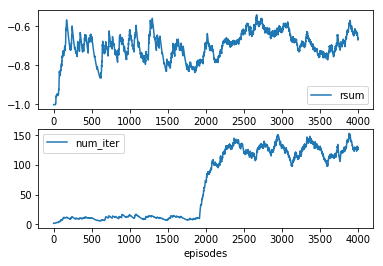

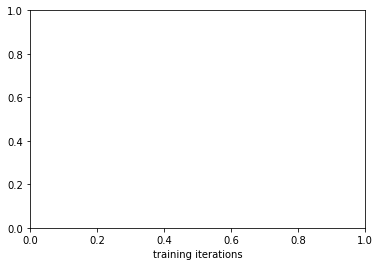

In [27]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
#     print(val_dict[k])
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.99), label=k)
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
keys = agent.log_dict.keys()
val_dict = agent.log_dict
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
plt.xlabel("training iterations")
plt.show()
